# Import

In [586]:
import numpy as np
import pandas as pd
import math, itertools
from itertools import combinations, product
from typing import List, Dict, Tuple, Iterable

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go
from plotly.colors import sample_colorscale

from scipy.optimize import linprog
from scipy.optimize import minimize
import torch, torch.nn.functional as F
import cvxpy as cp

# Toy Case

## Checking Inequalities

| **column in the DataFrame** | **what it measures**                                                                      | **inequality it should satisfy** |
| --------------------------- | ----------------------------------------------------------------------------------------- | -------------------------------- |
| `max_diff_over_grad`        | $\displaystyle\max_{x'}\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J\|_2\,\|x'-x\|_2}$ | ≤ 1                              |
| `max_grad_over_Li`          | $\displaystyle\max_{x'}\frac{\sqrt2\,\|J\|_2\,\|x'-x\|_2}{L_i\,\|x'-x\|_2}$              | ≤ 1                              |
| `max_diff_over_Li`          | $\displaystyle\max_{x'}\frac{\lvert\psi(x')-\psi(x)\rvert}{L_i\,\|x'-x\|_2}$             | ≤ 1                              |


In [2]:
def spec_norm(M):
    return np.linalg.svd(M, compute_uv=False)[0]

def psi(x, y, W1, W2):
    z = W2 @ np.maximum(W1 @ x, 0.)
    p = np.exp(z - z.max()); p /= p.sum()
    return -np.log((p * y).sum())

def run(seed, n=4, n1=3, K=3,
        trials=400, noise=0.7):
    rng = np.random.default_rng(seed)

    # network
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K,  n1))

    # base sample
    x = rng.standard_normal(n)
    y = np.array([0.,1.,0.])

    # Jacobian norm at x
    D  = np.diag((W1 @ x) > 0)
    J  = W2 @ D @ W1
    Jn = spec_norm(J)

    # global Lipschitz constant
    masks = np.array(np.meshgrid([0,1],[0,1],[0,1])).T.reshape(-1,3)
    L_i   = np.sqrt(2) * max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    r1 = r2 = r3 = 0.0
    for _ in range(trials):
        x_p = x + noise * rng.standard_normal(n)
        d   = np.linalg.norm(x_p - x)
        if d == 0: continue

        diff   = abs(psi(x_p, y, W1, W2) - psi(x, y, W1, W2))
        bound1 = np.sqrt(2) * Jn * d
        bound2 = L_i * d

        r1 = max(r1, diff / bound1)   # should ≤ 1
        r2 = max(r2, bound1 / bound2) # should ≤ 1
        r3 = max(r3, diff / bound2)   # should ≤ 1

    return dict(seed=seed, J_norm=Jn, L_i=L_i,
                max_diff_over_grad=r1,
                max_grad_over_Li=r2,
                max_diff_over_Li=r3)

df = pd.DataFrame([run(s) for s in range(5)])
df

,seed,J_norm,L_i,max_diff_over_grad,max_grad_over_Li,max_diff_over_Li
0,0,2.953623,4.177054,0.734026,1.000000,0.734026
1,1,1.983684,2.805353,0.062318,1.000000,0.062318
2,2,1.402538,5.058292,1.078396,0.392126,0.422867
3,3,4.276725,6.048203,0.724672,1.000000,0.724672
4,4,6.219832,9.575248,0.151276,0.918636,0.138968


| column name in the DataFrame| what the numbers are|
|---------------------------- | ------------------- |
| `ratio_single`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J\|_2\,\|x'-x\|_2}$|
| `ratio_path`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J^{(*)}\|_2\,\|x'-x\|_2}$ |
| `ratio_Li`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{L_i\,\|x'-x\|_2}$|
| `n_segs`| how many linear **segments** the straight path $x \to x'$ was broken into|


In [3]:
# --- hyper-parameters ---
n, n1, K  = 4, 3, 3       # dims
N_pairs   = 200           # how many x′ to test
grid_pts  = 300           # samples along [0,1] to detect mask changes
rng       = np.random.default_rng(0)

# --- helper: spectral 2-norm ---
spec = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# --- build one random network + anchor sample (x,y) ---
W1 = rng.standard_normal((n1, n))
W2 = rng.standard_normal((K , n1))
x  = rng.standard_normal(n)
y  = np.eye(K)[1]                # one-hot label “class 1”

# Jacobian and mask at the anchor point
a1   = W1 @ x
D0   = np.diag(a1 > 0)
J0   = W2 @ D0 @ W1
J0_n = spec(J0)

# global Lipschitz constant  L_i = √2 max_D ‖W2DW1‖
masks = np.array(np.meshgrid([0,1],[0,1],[0,1])).T.reshape(-1,3)
L_i   = np.sqrt(2)*max(spec(W2 @ np.diag(m) @ W1) for m in masks)

def psi(x_vec):
    z = W2 @ np.maximum(W1 @ x_vec, 0.)
    p = np.exp(z - z.max()); p /= p.sum()
    return -np.log(p[1])          # class-1 CE loss

records = []

for _ in range(N_pairs):
    x_p = x + rng.standard_normal(n)          # new target x′
    diff = abs(psi(x_p) - psi(x))
    dist = np.linalg.norm(x_p - x)

    # --- single-cell bound (should hold if x′ stays in same mask) ---
    b_single = np.sqrt(2)*J0_n*dist
    ratio_single = diff / b_single

    # --- pathwise bound (follow straight line, detect mask flips) ---
    ts = np.linspace(0,1,grid_pts+1)
    seg_masks, seg_Jnorm, seg_len = [], [], []

    last_t, last_x = 0.0, x
    last_mask = (W1 @ last_x > 0)

    for t in ts[1:]:
        xx = x + t*(x_p - x)
        mask = (W1 @ xx > 0)
        if not np.array_equal(mask, last_mask):  # boundary crossed
            seg_masks.append(last_mask)
            seg_Jnorm.append(spec(W2 @ np.diag(last_mask) @ W1))
            seg_len.append(np.linalg.norm(xx - last_x))
            last_t, last_x, last_mask = t, xx, mask

    # include final tiny segment (if any)
    if last_t < 1.0:
        seg_masks.append(last_mask)
        seg_Jnorm.append(spec(W2 @ np.diag(last_mask) @ W1))
        seg_len.append(np.linalg.norm(x_p - last_x))

    Jmax = max(seg_Jnorm)
    path_bound = np.sqrt(2)*Jmax*sum(seg_len)
    ratio_path = diff / path_bound
    ratio_Li   = diff / (L_i*dist)

    records.append(dict(diff=diff,
                        dist=dist,
                        ratio_single=ratio_single,
                        ratio_path=ratio_path,
                        ratio_Li=ratio_Li,
                        n_segs=len(seg_len)))

pd.DataFrame(records).describe()[["ratio_single","ratio_path","ratio_Li","n_segs"]]


,ratio_single,ratio_path,ratio_Li,n_segs
count,200.000000,200.000000,200.000000,200.000000
mean,0.178067,0.178067,0.178067,2.055000
std,0.179381,0.179381,0.179381,1.003499
min,0.001704,0.001704,0.001704,1.000000
25%,0.048484,0.048484,0.048484,1.000000
50%,0.092309,0.092309,0.092309,2.000000
75%,0.260301,0.260301,0.260301,3.000000
max,0.704814,0.704814,0.704814,4.000000


| column                       | what it is|
| ---------------------------- | ------------------------------------------                         |
| **`‖W2‖₂·‖W1‖₂`**            | product of the *individual* spectral norms                         |                
| **`‖W2·W1‖₂`**               | spectral norm of the *full* linear map $W_2W_1$ (no ReLU masking)  |
| **`max‖W2·D·W1‖₂`**          | largest norm over all $2^{\,n_1}$ binary masks $D$                 |
| **`min‖W2·D·W1‖₂`**          | smallest masked norm                                               |
| **`ratio (max / prod)`**     | $\dfrac{\text{max‖W2DW1‖₂}}{\|W_2\|_2\|W_1\|_2}$                   |
| **`ratio (max / full)`**     | $\dfrac{\text{max‖W2DW1‖₂}}{\|W_2W_1\|_2}$                         |


In [4]:
def spec_norm(M):
    """Spectral (operator-2) norm."""
    return np.linalg.svd(M, compute_uv=False)[0]

def compare_norms(seed, n=4, n1=3, K=3):
    rng = np.random.default_rng(seed)
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K,  n1))

    # individual layer norms
    norm_W1 = spec_norm(W1)
    norm_W2 = spec_norm(W2)
    prod_norm = norm_W1 * norm_W2          # ‖W2‖₂ · ‖W1‖₂

    # full linear map
    full_norm = spec_norm(W2 @ W1)         # ‖W2·W1‖₂

    # enumerate every binary mask D  (2^{n1} masks for small n1)
    masks = np.array(np.meshgrid(*[[0, 1]] * n1)).T.reshape(-1, n1)
    mask_norms = [spec_norm(W2 @ np.diag(m) @ W1) for m in masks]
    max_mask = max(mask_norms)
    min_mask = min(mask_norms)

    return {
        "seed": seed,
        "‖W2‖₂·‖W1‖₂": prod_norm,
        "‖W2·W1‖₂": full_norm,
        "max‖W2·D·W1‖₂": max_mask,
        "min‖W2·D·W1‖₂": min_mask,
        "ratio (max / prod)": max_mask / prod_norm,
        "ratio (max / full)": max_mask / full_norm if full_norm else np.nan
    }

# run for a few random seeds
df = pd.DataFrame(compare_norms(s) for s in range(5))
df

,seed,‖W2‖₂·‖W1‖₂,‖W2·W1‖₂,max‖W2·D·W1‖₂,min‖W2·D·W1‖₂,ratio (max / prod),ratio (max / full)
0,0,5.539950,2.809167,2.953623,0.0,0.533150,1.051423
1,1,2.128710,1.960581,1.983684,0.0,0.931872,1.011784
2,2,4.894370,3.544063,3.576753,0.0,0.730789,1.009224
3,3,6.046203,4.276725,4.276725,0.0,0.707341,1.000000
4,4,9.185035,6.219832,6.770723,0.0,0.737147,1.088570


## Checking Bounds

In [5]:
# ---------- core routine: runs ONE seed ----------
def run_once(seed, n=4, n1=3, K=3, probe_samples=1000, noise_scale=0.5):
    rng = np.random.default_rng(seed)      # use Generator API (no global state)

    # draw weights, point, and label
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K,  n1))
    x  = rng.standard_normal(n)
    y  = np.array([0., 1., 0.])            # class-1 one-hot

    def psi(x_vec):
        z = W2 @ np.maximum(W1 @ x_vec, 0)
        p = np.exp(z) / np.exp(z).sum()
        return -np.log(p[1])               # −log p(class 1)

    # Lipschitz bound L^{(i)}
    MASKS = np.array(np.meshgrid([0, 1], [0, 1], [0, 1])).T.reshape(-1, 3)
    spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]
    L = max(spec_norm(W2 @ np.diag(mask) @ W1) for mask in MASKS) * np.sqrt(2)

    # empirical ratios
    ratios = []
    for _ in range(probe_samples):
        x_prime = x + noise_scale * rng.standard_normal(n)
        diff  = abs(psi(x_prime) - psi(x))
        dist  = np.linalg.norm(x_prime - x)
        if dist > 0:
            ratios.append(diff / dist)

    print(f"seed {seed:3d} | L = {L:6.3f} | max ratio = {max(ratios):6.3f}")

# ---------- sweep over many seeds ----------
def sweep_seeds(seeds=(0, 1, 2, 3, 4)):
    for s in seeds:
        run_once(s)

# ---------- run it ----------
sweep_seeds(range(10))        # change range or pass an explicit list

seed   0 | L =  4.177 | max ratio =  3.027
seed   1 | L =  2.805 | max ratio =  0.062
seed   2 | L =  5.058 | max ratio =  2.227
seed   3 | L =  6.048 | max ratio =  4.390
seed   4 | L =  9.575 | max ratio =  1.159
seed   5 | L =  5.941 | max ratio =  4.039
seed   6 | L =  9.580 | max ratio =  0.824
seed   7 | L =  6.980 | max ratio =  0.847
seed   8 | L = 10.964 | max ratio =  3.354
seed   9 | L =  7.583 | max ratio =  4.053


In [6]:
# ------------------------------
# helpers
# ------------------------------
def relu(z):                # element-wise ReLU
    return np.maximum(z, 0.)

def softmax(z):
    z = z - z.max()         # numerical stability
    e = np.exp(z)
    return e / e.sum()

def cross_entropy(p, y_onehot):
    return -np.log((p * y_onehot).sum())

def spec_norm(M):
    # spectral (operator-2) norm via SVD
    return np.linalg.svd(M, compute_uv=False)[0]

# enumerate all 2^3 = 8 activation masks for n1 = 3
MASKS = np.array(np.meshgrid([0,1], [0,1], [0,1])).T.reshape(-1,3)

# ------------------------------
# main experiment
# ------------------------------
def train_and_check(seed=0,
                    n=4, n1=3, K=3,
                    n_train=200,
                    lr=0.05,
                    steps=500,
                    noise_scale=0.5,
                    probe_samples=1000):
    
    rng = np.random.default_rng(seed)
    
    # ----- tiny synthetic classification problem -----
    X = rng.standard_normal((n_train, n))
    y_int = rng.integers(0, K, size=n_train)
    Y = np.eye(K)[y_int]              # one-hot
    
    # ----- initialise weights -----
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K, n1))
    
    # SGD loop ---------------------------------------------------------
    for step in range(steps):
        idx = rng.integers(0, n_train)          # draw one sample
        x, y = X[idx], Y[idx]
        
        # forward pass
        h  = relu(W1 @ x)                       # hidden layer
        z  = W2 @ h
        p  = softmax(z)
        L  = cross_entropy(p, y)
        
        # backward pass
        dL_dz       = p - y                    # K-vector
        dL_dW2      = np.outer(dL_dz, h)       # (K×n1)
        
        dh          = W2.T @ dL_dz
        dh[z[:n1] <= 0] = 0                    # ReLU back-gate
        dL_dW1      = np.outer(dh, x)          # (n1×n)
        
        # SGD update
        W2 -= lr * dL_dW2
        W1 -= lr * dL_dW1
    
    # pick one training point to test the theory on -------------------
    x_i, y_i = X[0], Y[0]                      # (x^{(i)}, y^{(i)})
    
    # compute exact per-sample Lipschitz bound L^{(i)}
    #   L^{(i)} = √2 · max_D || W2 D W1 ||_2   over all 0/1 masks
    L_i = max(spec_norm(W2 @ np.diag(mask) @ W1) for mask in MASKS) * np.sqrt(2)
    
    # empirical finite differences around x^{(i)}
    ratios = []
    psi    = lambda x_vec: cross_entropy(
                 softmax(W2 @ relu(W1 @ x_vec)), y_i)
    
    for _ in range(probe_samples):
        x_prime = x_i + noise_scale * rng.standard_normal(n)
        diff    = abs(psi(x_prime) - psi(x_i))
        dist    = np.linalg.norm(x_prime - x_i)
        if dist > 0: ratios.append(diff / dist)
    
    print(f"seed {seed:3d} | L^{{(i)}} = {L_i:6.3f} | "
          f"max empirical ratio = {max(ratios):6.3f}")

# ------------------------------
# sweep over many seeds
# ------------------------------
def sweep_seeds(seeds=(0, 1, 2, 3, 4)):
    for s in seeds:
        train_and_check(seed=s)


sweep_seeds(range(10))        

seed   0 | L^{(i)} =  4.891 | max empirical ratio =  0.177
seed   1 | L^{(i)} =  9.664 | max empirical ratio =  0.307
seed   2 | L^{(i)} =  1.917 | max empirical ratio =  0.228
seed   3 | L^{(i)} =  3.200 | max empirical ratio =  0.207
seed   4 | L^{(i)} =  5.583 | max empirical ratio =  0.272
seed   5 | L^{(i)} =  4.067 | max empirical ratio =  0.386
seed   6 | L^{(i)} =  1.043 | max empirical ratio =  0.139
seed   7 | L^{(i)} =  3.120 | max empirical ratio =  0.128
seed   8 | L^{(i)} =  5.217 | max empirical ratio =  1.446
seed   9 | L^{(i)} =  7.049 | max empirical ratio =  0.312


In [7]:
# ----- choose seed & draw weights/point exactly as before -----
seed = 0
rng  = np.random.default_rng(seed)
n, n1, K = 4, 3, 3
W1 = rng.standard_normal((n1, n))
W2 = rng.standard_normal((K,  n1))
x  = rng.standard_normal(n)
y  = 1                             # class index 0,1,2

# ----- forward pass for point x -----
h = np.maximum(W1 @ x, 0.)         # ReLU activations
D = np.diag(h > 0)                 # 0/1 mask
z = W2 @ h
z -= z.max()                       # softmax stabilisation
p = np.exp(z) / np.exp(z).sum()

# ----- gradient wrt x (closed form) -----
g = (p - np.eye(K)[y]) @ W2 @ D @ W1     # row-vector (shape (n,))
grad_norm = np.linalg.norm(g, 2)

# ----- Lipschitz bound L^{(i)} -----
masks = np.array(np.meshgrid([0,1],[0,1],[0,1])).T.reshape(-1,3)
spec = lambda M: np.linalg.svd(M, compute_uv=False)[0]
L_i  = max(spec(W2 @ np.diag(m) @ W1) for m in masks) * np.sqrt(2)

print(f"‖∇ψ(x)‖₂  = {grad_norm:.6f}")
print(f"L^(i)    = {L_i:.6f}")
print(f"gap (L - ‖∇ψ‖) = {L_i - grad_norm:.6f}")

‖∇ψ(x)‖₂  = 2.303780
L^(i)    = 4.177054
gap (L - ‖∇ψ‖) = 1.873274


In [8]:
def grad_norm_and_L(seed, n=4, n1=3, K=3):
    """
    Draw W1, W2, x with the given seed and compute
    ‖∇ψ(x)‖₂, L^{(i)}, and their gap.
    """
    rng = np.random.default_rng(seed)

    # random weights and single data point
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K,  n1))
    x  = rng.standard_normal(n)
    y  = 1                       # fixed target class index (0,1,2)

    # forward pass
    h = np.maximum(W1 @ x, 0.)   # ReLU activations
    D = np.diag(h > 0)           # 0/1 mask
    z = W2 @ h
    z -= z.max()                 # soft-max stabilisation
    p = np.exp(z) / np.exp(z).sum()

    # gradient wrt x
    g = (p - np.eye(K)[y]) @ W2 @ D @ W1
    grad_norm = np.linalg.norm(g, 2)

    # Lipschitz constant L^{(i)}
    masks = np.array(np.meshgrid([0,1],[0,1],[0,1])).T.reshape(-1,3)  # 8 masks
    spec = lambda M: np.linalg.svd(M, compute_uv=False)[0]            # spectral norm
    L_i  = max(spec(W2 @ np.diag(m) @ W1) for m in masks) * np.sqrt(2)

    return grad_norm, L_i, L_i - grad_norm

# ---------- customise your seeds here ----------
seeds = range(10)          # e.g. [0, 1, 2, 42, 777]

# run the sweep
records = []
for s in seeds:
    grad_norm, L_i, gap = grad_norm_and_L(s)
    records.append({"seed": s,
                    "grad_norm": grad_norm,
                    "L_i": L_i,
                    "gap": gap})

results = pd.DataFrame(records)
results

,seed,grad_norm,L_i,gap
0,0,2.303780,4.177054,1.873274
1,1,0.006185,2.805353,2.799168
2,2,1.436533,5.058292,3.621759
3,3,3.829224,6.048203,2.218979
4,4,0.006055,9.575248,9.569192
5,5,1.450012,5.940553,4.490541
6,6,0.113865,9.579810,9.465945
7,7,0.707435,6.980455,6.273020
8,8,0.125458,10.963726,10.838268
9,9,4.030900,7.582992,3.552091


## Compare with Rui Gao

Our Problem
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] 
\leq \max_{i=1,...,N} L_\beta^{\{Z^{(i)}\}}\delta
\;
$$
$$
\mathfrak{M}_1 := \{\mathbb{P}\in \mathcal{P}(\mathcal{Z}) \ | \ \mathcal{W}_{d,1}(\mathbb{P}, \mathbb{P}_N) \leq \delta \}
$$

Rui Gao
$$
\left| \mathcal R_{\mathbb P_n,2}(\rho_n;f_\theta)-\rho_n\,\left\|\left\|\nabla f_\theta\right\|_{*}\right\|_{\mathbb P_n,2} \right|
\;\le\;
C_1\rho_n^{\!2}
\;+\;
C_2\,d_1\sqrt{\frac{d}{n}}
\;+\;
\rho_n\sqrt{\frac{t}{2n}}
$$
$$
\mathcal R_{\mathbb P_N,2}(\delta;\psi_\beta) = \sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] 
$$
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] \leq \delta\,\left\|\left\|\nabla \psi_\beta\right\|_{*}\right\|_{\mathbb P_N,2} + C_1\delta^{2}
\;+\;
C_2\,n_1\sqrt{\frac{n}{N}}
\;+\;
\delta\sqrt{\frac{t}{2N}}
$$
$$
C_1=\tfrac18, \quad C_2=\sqrt3.
$$
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] \leq \delta\,\left\|\left\|\nabla \psi_\beta\right\|_{*}\right\|_{\mathbb P_N,2} + \tfrac18\delta^{2}
\;+\;
\sqrt3\,n_1\sqrt{\frac{n}{N}}
\;+\;
\delta\sqrt{\frac{t}{2N}}
$$

$$
\;
\underbrace{\mathbb{E}_{\mathbb{P}_N}\bigl[\psi_{\beta}(Z)\bigr]
            +\sum_{i=1}^{N}\mu_i\,L_{(i)}\;\delta}_{\displaystyle\widehat{\mathcal{L}}}
\;\;\le\;\;
\sup_{\mathbb{P}:W_{d,1}(\mathbb{P},\mathbb{P}_N)\le\delta}
      \mathbb{E}_{\mathbb{P}}\bigl[\psi_{\beta}(Z)\bigr]
\;\;\le\;\;
\underbrace{\mathbb{E}_{\mathbb{P}_N}\bigl[\psi_{\beta}(Z)\bigr]
            +\Bigl(\max_{i=1,\dots,N}L_{(i)}\Bigr)\,\delta}_{\displaystyle\widehat{\mathcal{U}}}
\;
$$

$$
\;
\sum_{i=1}^{N}\mu_i\,L_{(i)}\;\delta
\;\;\le\;\;
\sup_{\mathbb{P}:W_{d,1}(\mathbb{P},\mathbb{P}_N)\le\delta}
      \mathbb{E}_{\mathbb{P}}\bigl[\psi_{\beta}(Z)\bigr] - \mathbb{E}_{\mathbb{P}_N}\bigl[\psi_{\beta}(Z)\bigr]
\;\;\le\;\;
\Bigl(\max_{i=1,\dots,N}L_{(i)}\Bigr)\,\delta
\;
$$

$$
\sup_{\mathbb{P}:W_{d,1}(\mathbb{P},\mathbb{P}_N)\le\delta}
      \mathbb{E}_{\mathbb{P}}\bigl[\psi_{\beta}(Z)\bigr] - \mathbb{E}_{\mathbb{P}_N}\bigl[\psi_{\beta}(Z)\bigr]
\;\;=\;\;
L\,\delta
\;
$$

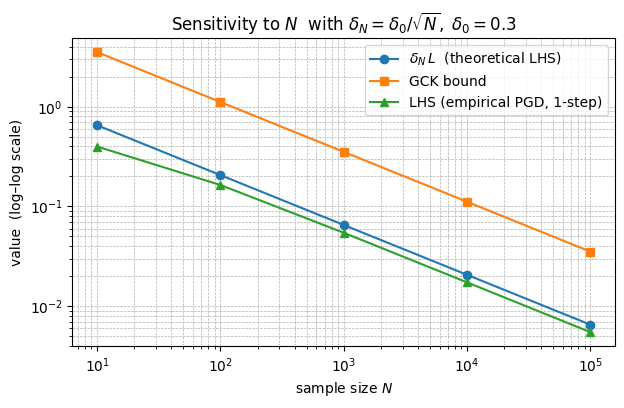

In [9]:
# ours vs GCK vs empirical LHS
# ================================================

# ------------ helper -------------
spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# ------------ hyper-parameters ----
n, n1, K   = 4, 3, 3
seeds      = range(10)
Ns         = np.logspace(1, 5, num=5, base=10, dtype=int)   # 10 … 1e5
delta0     = 0.3
t          = 1.0

rows = []

for seed in seeds:
    rng = np.random.default_rng(seed)

    # random network
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K , n1))

    # global Lipschitz L = √2 max_D ‖W2 D W1‖₂
    masks = np.array(list(itertools.product([0,1], repeat=n1)))
    L_net = math.sqrt(2)*max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    for N in Ns:
        delta_N = delta0 / math.sqrt(N)

        # sample data
        X = rng.standard_normal((N, n))
        Y = np.eye(K)[rng.integers(0, K, size=N)]

        grad_sq, worst_diffs = [], []
        for x, y in zip(X, Y):
            a1  = W1 @ x
            D   = np.diag(a1 > 0)
            z   = W2 @ np.maximum(a1, 0.0)
            p   = np.exp(z - z.max()); p /= p.sum()
            g   = (p - y) @ W2 @ D @ W1
            gn  = np.linalg.norm(g)
            grad_sq.append(gn**2)

            # one-step adversarial move (empirical inner sup)
            if gn > 0:
                x_adv = x + delta_N * g / gn
                z_adv = W2 @ np.maximum(W1 @ x_adv, 0.0)
                p_adv = np.exp(z_adv - z_adv.max()); p_adv /= p_adv.sum()
                diff  = -np.log((p_adv * y).sum()) + np.log((p * y).sum())
                worst_diffs.append(diff)

        grad_emp = math.sqrt(np.mean(grad_sq))
        lhs_emp  = max(worst_diffs) if worst_diffs else 0.0   # empirical LHS

        ours  = delta_N * L_net                               # exact LHS (theory)
        gck   = (delta_N*grad_emp + 0.125*delta_N**2
                 + math.sqrt(3)*n1*math.sqrt(n/N)
                 + delta_N*math.sqrt(t/(2*N)))

        rows.append(dict(seed=seed, N=N,
                         ours=ours, gck=gck, lhs_emp=lhs_emp))

# ------------ aggregate -------------
df = pd.DataFrame(rows).groupby("N").mean().reset_index()

# ------------ plot -------------------
plt.figure(figsize=(7,4))
plt.plot(df.N, df.ours,     marker="o", label=r"$\delta_N\,L$  (theoretical LHS)")
plt.plot(df.N, df.gck,      marker="s", label=r"GCK bound")
plt.plot(df.N, df.lhs_emp,  marker="^", label=r"LHS (empirical PGD, 1-step)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(fr"Sensitivity to $N$  with $\delta_N=\delta_0/\sqrt{{N}},\;\delta_0={delta0}$")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(); plt.show()

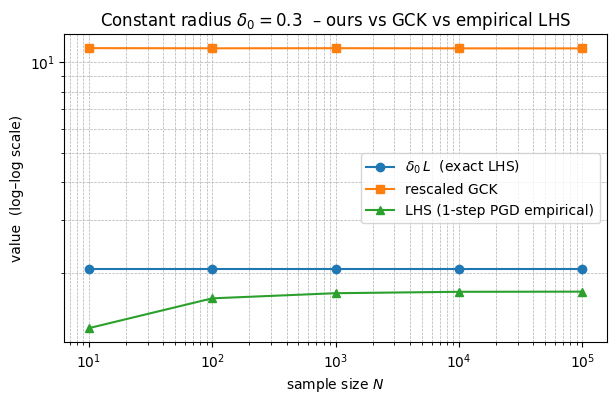

In [10]:
# =============================================================
# helper
# =============================================================
spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# =============================================================
# hyper-parameters
# =============================================================
n, n1, K   = 4, 3, 3
seeds      = range(10)                             # average over 10 nets
Ns         = np.logspace(1, 5, num=5, base=10, dtype=int)   # 1e1 … 1e5
delta0     = 0.3                                   # constant radius
t          = 1.0                                   # GCK confidence term

rows = []

for seed in seeds:
    rng = np.random.default_rng(seed)

    # -------- random 2-layer ReLU network (fixed across N) --------
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K , n1))

    # global Lipschitz  L = √2·max_D ||W2 D W1||₂  (8 masks for n1=3)
    masks  = np.array(list(itertools.product([0,1], repeat=n1)))
    L_net  = math.sqrt(2) * max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    for N in Ns:
        delta_N = delta0 / math.sqrt(N)            # radius in GCK theorem

        # ------------- sample data (for grad_emp & empirical LHS) -------------
        X = rng.standard_normal((N, n))
        Y = np.eye(K)[rng.integers(0, K, size=N)]

        grad_sq, diff_emp = [], []

        for x, y in zip(X, Y):
            # forward
            a1  = W1 @ x
            D   = np.diag(a1 > 0)
            z   = W2 @ np.maximum(a1, 0.0)
            p   = np.exp(z - z.max()); p /= p.sum()

            # gradient wrt x
            g   = (p - y) @ W2 @ D @ W1
            gn  = np.linalg.norm(g)
            grad_sq.append(gn**2)

            # one-step PGD adversary with radius δ0  -------
            if gn > 0:
                x_adv = x + delta0 * g / gn
                z_adv = W2 @ np.maximum(W1 @ x_adv, 0.0)
                p_adv = np.exp(z_adv - z_adv.max()); p_adv /= p_adv.sum()
                diff  = -np.log((p_adv * y).sum()) + np.log((p * y).sum())
                diff_emp.append(diff)

        grad_emp = math.sqrt(np.mean(grad_sq))
        lhs_emp  = max(diff_emp) if diff_emp else 0.0      # empirical sup

        # ---------------- bounds -----------------
        ours          = delta0 * L_net                     # theoretical LHS
        gck_original  = (delta_N*grad_emp + 0.125*delta_N**2
                         + math.sqrt(3)*n1*math.sqrt(n/N)
                         + delta_N*math.sqrt(t/(2*N)))
        gck_rescaled  = gck_original * math.sqrt(N)        # put on δ0 scale

        rows.append(dict(seed=seed, N=N,
                         ours=ours,
                         gck=gck_rescaled,
                         lhs_emp=lhs_emp))

# =============================================================
# aggregate & plot
# =============================================================
df = pd.DataFrame(rows).groupby("N").mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(df.N, df.ours,     marker="o", label=r"$\delta_0\,L$  (exact LHS)")
plt.plot(df.N, df.gck,      marker="s", label=r"rescaled GCK")
plt.plot(df.N, df.lhs_emp,  marker="^", label=r"LHS (1-step PGD empirical)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(fr"Constant radius $\delta_0={delta0}$  – ours vs GCK vs empirical LHS")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(); plt.show()

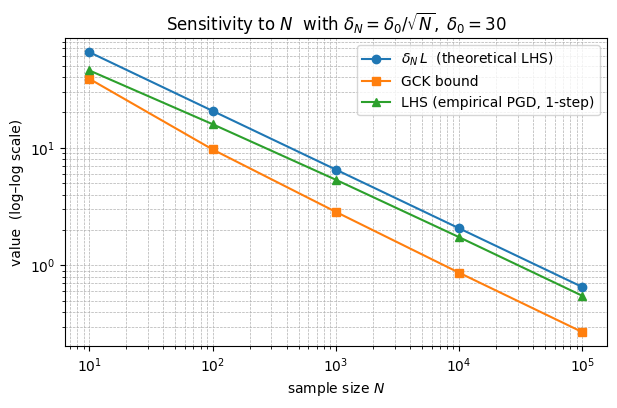

In [11]:
# ours vs GCK vs empirical LHS
# ================================================

# ------------ helper -------------
spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# ------------ hyper-parameters ----
n, n1, K   = 4, 3, 3
seeds      = range(10)
Ns         = np.logspace(1, 5, num=5, base=10, dtype=int)   # 10 … 1e5
delta0     = 30
t          = 1.0

rows = []

for seed in seeds:
    rng = np.random.default_rng(seed)

    # random network
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K , n1))

    # global Lipschitz L = √2 max_D ‖W2 D W1‖₂
    masks = np.array(list(itertools.product([0,1], repeat=n1)))
    L_net = math.sqrt(2)*max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    for N in Ns:
        delta_N = delta0 / math.sqrt(N)

        # sample data
        X = rng.standard_normal((N, n))
        Y = np.eye(K)[rng.integers(0, K, size=N)]

        grad_sq, worst_diffs = [], []
        for x, y in zip(X, Y):
            a1  = W1 @ x
            D   = np.diag(a1 > 0)
            z   = W2 @ np.maximum(a1, 0.0)
            p   = np.exp(z - z.max()); p /= p.sum()
            g   = (p - y) @ W2 @ D @ W1
            gn  = np.linalg.norm(g)
            grad_sq.append(gn**2)

            # one-step adversarial move (empirical inner sup)
            if gn > 0:
                x_adv = x + delta_N * g / gn
                z_adv = W2 @ np.maximum(W1 @ x_adv, 0.0)
                p_adv = np.exp(z_adv - z_adv.max()); p_adv /= p_adv.sum()
                diff  = -np.log((p_adv * y).sum()) + np.log((p * y).sum())
                worst_diffs.append(diff)

        grad_emp = math.sqrt(np.mean(grad_sq))
        lhs_emp  = max(worst_diffs) if worst_diffs else 0.0   # empirical LHS

        ours  = delta_N * L_net                               # exact LHS (theory)
        gck   = (delta_N*grad_emp + 0.125*delta_N**2
                 + math.sqrt(3)*n1*math.sqrt(n/N)
                 + delta_N*math.sqrt(t/(2*N)))

        rows.append(dict(seed=seed, N=N,
                         ours=ours, gck=gck, lhs_emp=lhs_emp))

# ------------ aggregate -------------
df = pd.DataFrame(rows).groupby("N").mean().reset_index()

# ------------ plot -------------------
plt.figure(figsize=(7,4))
plt.plot(df.N, df.ours,     marker="o", label=r"$\delta_N\,L$  (theoretical LHS)")
plt.plot(df.N, df.gck,      marker="s", label=r"GCK bound")
plt.plot(df.N, df.lhs_emp,  marker="^", label=r"LHS (empirical PGD, 1-step)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(fr"Sensitivity to $N$  with $\delta_N=\delta_0/\sqrt{{N}},\;\delta_0={delta0}$")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(); plt.show()


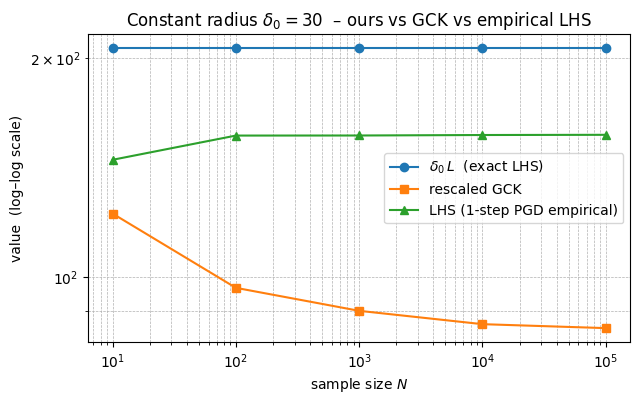

In [12]:
# =============================================================
# helper
# =============================================================
spec_norm = lambda M: np.linalg.svd(M, compute_uv=False)[0]

# =============================================================
# hyper-parameters
# =============================================================
n, n1, K   = 4, 3, 3
seeds      = range(10)                             # average over 10 nets
Ns         = np.logspace(1, 5, num=5, base=10, dtype=int)   # 1e1 … 1e5
delta0     = 30                                    # constant radius
t          = 1.0                                   # GCK confidence term

rows = []

for seed in seeds:
    rng = np.random.default_rng(seed)

    # -------- random 2-layer ReLU network (fixed across N) --------
    W1 = rng.standard_normal((n1, n))
    W2 = rng.standard_normal((K , n1))

    # global Lipschitz  L = √2·max_D ||W2 D W1||₂  (8 masks for n1=3)
    masks  = np.array(list(itertools.product([0,1], repeat=n1)))
    L_net  = math.sqrt(2) * max(spec_norm(W2 @ np.diag(m) @ W1) for m in masks)

    for N in Ns:
        delta_N = delta0 / math.sqrt(N)            # radius in GCK theorem

        # ------------- sample data (for grad_emp & empirical LHS) -------------
        X = rng.standard_normal((N, n))
        Y = np.eye(K)[rng.integers(0, K, size=N)]

        grad_sq, diff_emp = [], []

        for x, y in zip(X, Y):
            # forward
            a1  = W1 @ x
            D   = np.diag(a1 > 0)
            z   = W2 @ np.maximum(a1, 0.0)
            p   = np.exp(z - z.max()); p /= p.sum()

            # gradient wrt x
            g   = (p - y) @ W2 @ D @ W1
            gn  = np.linalg.norm(g)
            grad_sq.append(gn**2)

            # one-step PGD adversary with radius δ0  -------
            if gn > 0:
                x_adv = x + delta0 * g / gn
                z_adv = W2 @ np.maximum(W1 @ x_adv, 0.0)
                p_adv = np.exp(z_adv - z_adv.max()); p_adv /= p_adv.sum()
                diff  = -np.log((p_adv * y).sum()) + np.log((p * y).sum())
                diff_emp.append(diff)

        grad_emp = math.sqrt(np.mean(grad_sq))
        lhs_emp  = max(diff_emp) if diff_emp else 0.0      # empirical sup

        # ---------------- bounds -----------------
        ours          = delta0 * L_net                     # theoretical LHS
        gck_original  = (delta_N*grad_emp + 0.125*delta_N**2
                         + math.sqrt(3)*n1*math.sqrt(n/N)
                         + delta_N*math.sqrt(t/(2*N)))
        gck_rescaled  = gck_original * math.sqrt(N)        # put on δ0 scale

        rows.append(dict(seed=seed, N=N,
                         ours=ours,
                         gck=gck_rescaled,
                         lhs_emp=lhs_emp))

# =============================================================
# aggregate & plot
# =============================================================
df = pd.DataFrame(rows).groupby("N").mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(df.N, df.ours,     marker="o", label=r"$\delta_0\,L$  (exact LHS)")
plt.plot(df.N, df.gck,      marker="s", label=r"rescaled GCK")
plt.plot(df.N, df.lhs_emp,  marker="^", label=r"LHS (1-step PGD empirical)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(fr"Constant radius $\delta_0={delta0}$  – ours vs GCK vs empirical LHS")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(); plt.show()

## Checking Topology

$$\mathcal D = \mathcal D _{(i)}$$

In [623]:
# ============================================================
# Numerical check that  𝓓(i) = 𝓓  for a 1-hidden-layer
# ReLU network  f(x) = W2 · ReLU(W1 x)
# ============================================================

# ------------------------  hyper-parameters  ------------------------
np.random.seed(42)   # reproducibility

n_in, n_hidden, n_out = 5, 6, 1         # <<< tweak as you wish
max_random_search    = 200_000          # tries to find 1 witness / mask
num_samples_segment  = 120              # points along each straight segment
tail_fraction        = 0.20             # last 20 %  ≡  [t₁,1]

# ------------------------  random weights  --------------------------
W1 = np.random.randn(n_hidden, n_in)
W2 = np.random.randn(n_out,   n_hidden)

# ------------------------  helper functions  ------------------------
def relu_mask(x: np.ndarray) -> np.ndarray:
    """Return diagonal mask  D(x) = diag(1_{W1 x > 0})."""
    a = (W1 @ x > 0).astype(float)
    return np.diag(a)

def mask_to_int(D: np.ndarray) -> int:
    """Convert a diagonal {0,1} mask to an integer (bitstring)."""
    return int("".join(str(int(d)) for d in np.diag(D)), 2)

# ============================================================
# 1)  Monte-Carlo search for one witness x^D per *feasible* mask
# ============================================================
witness     : dict[int, np.ndarray] = {}          # mask_int -> x^D
tries_since_new = 0

for _ in range(max_random_search):
    x = np.random.randn(n_in) * 3                 # sample in a wide ball
    key = mask_to_int(relu_mask(x))
    if key not in witness:
        witness[key] = x
        tries_since_new = 0                       # reset counter
    else:
        tries_since_new += 1

    # simple early-stop: if no new mask appeared in a while, assume done
    if tries_since_new > 20_000:
        break

D_global = set(witness.keys())                    # 𝓓  (feasible masks)

print(f"Found {len(D_global)} distinct feasible masks "
      f"out of 2^{n_hidden} = {2**n_hidden} possibilities.")

# ============================================================
# 2)  Build  𝓓(i)  by walking straight segments to every x^D
# ============================================================
x_i  = np.random.randn(n_in)                      # reference point x^(i)
D_i  = set()

for key, xD in witness.items():
    segment = ( x_i
              + np.linspace(0.0, 1.0, num_samples_segment)[:, None]
              * (xD - x_i)
              )
    tail = segment[int((1 - tail_fraction) * num_samples_segment):]  # [t₁,1]
    for z in tail:
        D_i.add(mask_to_int(relu_mask(z)))

# ============================================================
# 3)  Compare the two sets
# ============================================================
fmt = lambda k: format(k, f"0{n_hidden}b")        # human-readable bitstring

print("\n𝓓     (feasible masks):")
print("  {" + ", ".join(sorted(fmt(k) for k in D_global)) + "}")

print("\n𝓓(i)  (segment-tail masks from x^(i)):")
print("  {" + ", ".join(sorted(fmt(k) for k in D_i)) + "}")

print("\nSets equal?", D_global == D_i)

Found 61 distinct feasible masks out of 2^6 = 64 possibilities.

𝓓     (feasible masks):
  {000000, 000001, 000010, 000011, 000100, 000101, 000111, 001000, 001001, 001010, 001011, 001100, 001101, 001110, 001111, 010000, 010001, 010010, 010011, 010100, 010101, 010111, 011000, 011001, 011010, 011011, 011100, 011101, 011110, 011111, 100000, 100001, 100010, 100011, 100100, 100101, 100110, 100111, 101000, 101010, 101011, 101100, 101101, 101110, 101111, 110000, 110001, 110010, 110011, 110100, 110101, 110110, 110111, 111000, 111001, 111010, 111011, 111100, 111101, 111110, 111111}

𝓓(i)  (segment-tail masks from x^(i)):
  {000000, 000001, 000010, 000011, 000100, 000101, 000111, 001000, 001001, 001010, 001011, 001100, 001101, 001110, 001111, 010000, 010001, 010010, 010011, 010100, 010101, 010111, 011000, 011001, 011010, 011011, 011100, 011101, 011110, 011111, 100000, 100001, 100010, 100011, 100100, 100101, 100110, 100111, 101000, 101010, 101011, 101100, 101101, 101110, 101111, 110000, 110001, 1

$$
J^*u = w
$$


=== NETWORK INGREDIENTS ===
W1 =
[[-0.9775  0.0692]
 [-0.0404 -0.3053]]

W2 =
[[-0.5414 -0.6144]
 [ 0.4635  1.1171]]

D* (bitstring) = 11
D* =
[[1 0]
 [0 1]]

J* =
[[ 0.554   0.1501]
 [-0.4982 -0.309 ]]

‖J*‖₂ = 0.8118

=== STRICT ReLU CELL 𝒞* ===
𝒞* = { x ∈ ℝ² :
       D*W1[0] · x  >  0   (⇒ -0.9775·x₁ +0.0692·x₂ > 0)
       D*W1[1] · x  >  0   (⇒ -0.0404·x₁ -0.3053·x₂ > 0)
     }

=== RECESSION CONE rec(𝒞*) ===
rec(𝒞*) = { u ≠ 0 :
             D*W1[0] · u  ≥  0   (⇒ -0.9775·u₁ +0.0692·u₂ ≥ 0)
             D*W1[1] · u  ≥  0   (⇒ -0.0404·u₁ -0.3053·u₂ ≥ 0)
           }

Ω = int(rec(𝒞*))  (all inequalities strict)

=== IMAGE CONE V  AND  SLICE V* ===
V   = J* Ω   (linear image of the interior cone)
Sphere radius = ‖J*‖₂ = 0.8118
V*  = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on that circle)

=== PROOF VECTOR w ===
w = [-0.5741  0.5741]
‖w‖₂ = 0.8118 (matches ‖J*‖₂)


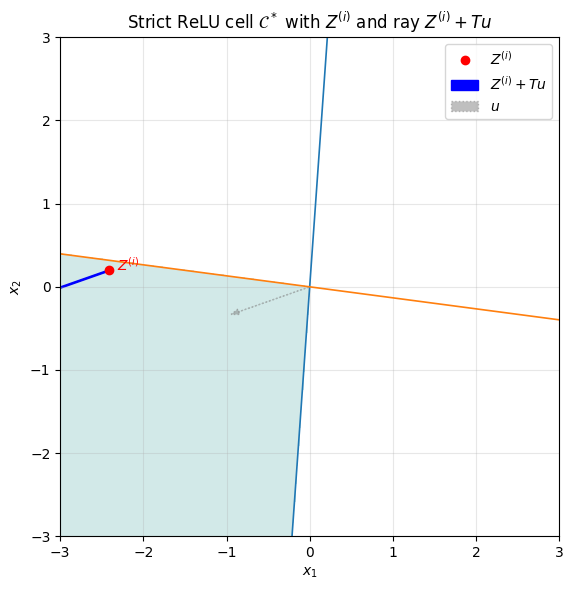

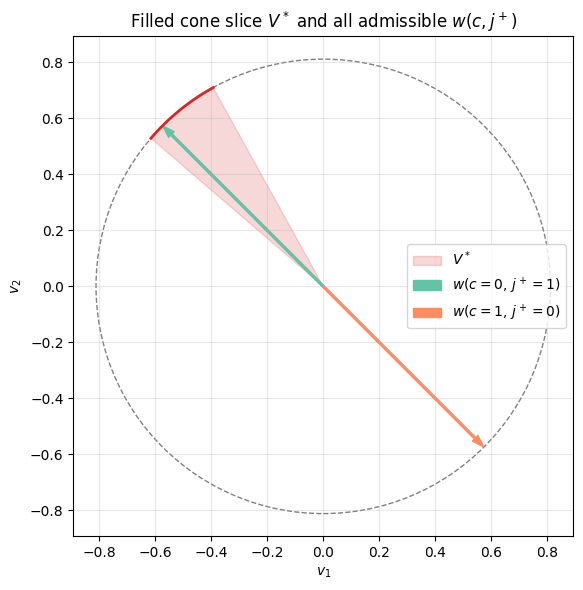

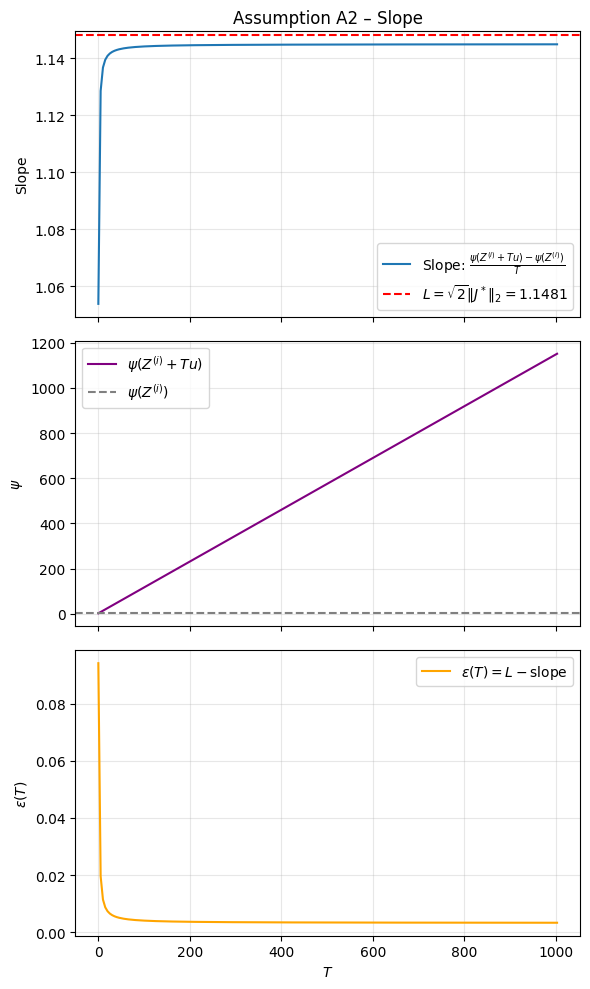

In [624]:

# 162840------------------------------------------------------------------
# 0.  Build W1, W2, D*  **with   rank(J*) = 2** guaranteed
# ------------------------------------------------------------------
seed = 162840
rng  = np.random.default_rng(seed)

def random_fullrank_2x2(rng):
    while True:
        W = rng.standard_normal((2, 2))
        if abs(np.linalg.det(W)) > 1e-3:
            return W

while True:
    W1 = random_fullrank_2x2(rng)
    W2 = rng.standard_normal((2, 2))

    # choose D* exactly as before
    best_val, D_star = -np.inf, None
    for bits in range(4):
        D = np.diag([(bits >> k) & 1 for k in range(2)])
        val = np.linalg.svd(W2 @ D @ W1, compute_uv=False)[0]
        if val > best_val:
            best_val, D_star = val, D
    J_star = W2 @ D_star @ W1

    # accept only if J_star is full row rank (==2)
    if np.linalg.matrix_rank(J_star) == 2:
        break

# ------------------------------------------------------------
# 2.  Optimal mask D*  (exhaustive over 2^2 = 4 masks)
# ------------------------------------------------------------
def spectral_norm(A): return np.linalg.svd(A, compute_uv=False)[0]

best_val, D_star = -np.inf, None
for bits in range(4):
    D = np.diag([(bits >> k) & 1 for k in range(2)])
    val = spectral_norm(W2 @ D @ W1)
    if val > best_val:
        best_val, D_star = val, D

J_star = W2 @ D_star @ W1
radius = spectral_norm(J_star)

# ------------------------------------------------------------
# 3.  Strict ReLU cell 𝒞*  – dense grid sampling
# ------------------------------------------------------------
grid = np.linspace(-8, 8, 1000)          # wider window
xx, yy = np.meshgrid(grid, grid)
XY = np.c_[xx.ravel(), yy.ravel()]       # shape (M, 2)

mask = np.ones(XY.shape[0], dtype=bool)
for k in range(2):
    vals = XY @ W1[k]                    # a_k·x + b_k·y
    if D_star[k, k] == 1:                # neuron kept ⇒ strict “> 0”
        mask &= vals > 0
    else:                                # neuron killed ⇒ strict “< 0”
        mask &= vals < 0

C_pts = XY[mask]                         # points in 𝒞*

# ------------------------------------------------------------
# 4.  Image cone V = J*Ω  and vector w
# ------------------------------------------------------------
V_pts = (J_star @ C_pts.T).T

c, j_plus = 0, 1
e = np.eye(2)
w = (radius / np.sqrt(2)) * (e[j_plus] - e[c])   # proof vector

# ============================================================
# Nicely formatted symbolic print-out of all sets
# (assumes W1, W2, D_star, J_star, w, radius are defined)
# ============================================================
np.set_printoptions(precision=4, suppress=True)

def banner(t):
    print(f"\n=== {t} ===")

def mat(name, M):
    print(f"{name} =\n{M}\n")

# 0) Matrices & basic numbers --------------------------------
banner("NETWORK INGREDIENTS")
mat("W1", W1)
mat("W2", W2)
print("D* (bitstring) =", "".join(str(int(x)) for x in np.diag(D_star)))
mat("D*", D_star)
mat("J*", J_star)
print(f"‖J*‖₂ = {radius:.4f}")

# 1) Strict ReLU cell 𝒞* -------------------------------------
banner("STRICT ReLU CELL 𝒞*")
rows = []
for k in range(W1.shape[0]):
    coef = "D*W1" if D_star[k, k] == 1 else "(I−D*)W1"
    sign = ">" if D_star[k, k] == 1 else "<"
    a, b = (W1[k] if D_star[k, k] == 1 else W1[k]).round(4)
    rows.append(f"{coef}[{k}] · x  {sign}  0   "
                f"(⇒ {a:+.4f}·x₁ {b:+.4f}·x₂ {sign} 0)")
print("𝒞* = { x ∈ ℝ² :")
for r in rows:
    print("       " + r)
print("     }")

# 2) Recession cone & interior Ω -----------------------------
banner("RECESSION CONE rec(𝒞*)")
rows_rec = []
for k in range(W1.shape[0]):
    coef = "D*W1" if D_star[k, k] == 1 else "(I−D*)W1"
    cmp = "≥" if D_star[k, k] == 1 else "≤"
    a, b = (W1[k] if D_star[k, k] == 1 else W1[k]).round(4)
    rows_rec.append(f"{coef}[{k}] · u  {cmp}  0   "
                    f"(⇒ {a:+.4f}·u₁ {b:+.4f}·u₂ {cmp} 0)")
print("rec(𝒞*) = { u ≠ 0 :")
for r in rows_rec:
    print("             " + r)
print("           }")
print("\nΩ = int(rec(𝒞*))  (all inequalities strict)")

# 3) Image cone V and spherical slice V* ---------------------
banner("IMAGE CONE V  AND  SLICE V*")
print("V   = J* Ω   (linear image of the interior cone)")
print(f"Sphere radius = ‖J*‖₂ = {radius:.4f}")
print("V*  = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on that circle)")

# 4) Proof vector w ------------------------------------------
banner("PROOF VECTOR w")
print("w =", w.round(4))
print(f"‖w‖₂ = {np.linalg.norm(w):.4f} (matches ‖J*‖₂)")

# ------------------------------------------------------------
# Reproducible plot of ReLU cell, Z^{(i)}, direction u, and ray Z^{(i)} + Tu
# ------------------------------------------------------------
# === reproducible RNG ===
rng = np.random.default_rng(seed=seed)

# 1) Reproducible test point anywhere in ℝ²
Z_i = rng.uniform(low=-2.5, high=2.5, size=2)

# 2) Reproducible direction u ∈ int(Ω)
u = np.linalg.solve(J_star, w)

# 3) Target ray end: Z^{(i)} + T_max u
T_max = 2
ray_end = Z_i + T_max * u

# 4) Boolean mask for the strict ReLU cell 𝒞*
cond = np.ones_like(xx, dtype=bool)
for k in range(2):
    lin = W1[k, 0] * xx + W1[k, 1] * yy
    if D_star[k, k] == 1:
        cond &= (lin > 0)
    else:
        cond &= (lin < 0)

# --- Plot ---
plt.figure(figsize=(6, 6))

# 1) Shade the strict ReLU cell
plt.contourf(xx, yy, cond.astype(int), levels=[0.5, 1.5], alpha=0.20)

# 2) Plot decision boundaries
x_line = np.linspace(-4, 4, 900)
for k in range(2):
    a, b = W1[k]
    style = '-' if D_star[k, k] == 1 else '--'
    if abs(b) > 1e-12:
        y_line = (-a / b) * x_line
        plt.plot(x_line, y_line, style, linewidth=1.2)
    else:
        plt.axvline(0, linestyle=style, linewidth=1.2)

# 3) Plot Z^{(i)} as red dot
plt.plot(Z_i[0], Z_i[1], 'ro', label=r"$Z^{(i)}$")
plt.text(Z_i[0] + 0.1, Z_i[1], r"$Z^{(i)}$", color='red')

# 4) Ray Z^{(i)} + T·u as blue arrow
plt.arrow(Z_i[0], Z_i[1],
          (ray_end - Z_i)[0], (ray_end - Z_i)[1],
          color='blue', width=0.015,
          head_width=0.1, head_length=0.15,
          length_includes_head=True,
          label=r"$Z^{(i)} + T u$")

# 5) Optional: gray dashed arrow showing u from origin
plt.arrow(0, 0, u[0], u[1],
          color='gray', alpha=0.5, linestyle=':',
          head_width=0.07, head_length=0.1,
          length_includes_head=True,
          label=r"$u$")

# --- Final formatting ---
plt.xlim([-3, 3]); plt.ylim([-3, 3])
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$')
plt.title(r'Strict ReLU cell $\mathcal{C}^*$ with $Z^{(i)}$ and ray $Z^{(i)} + Tu$')
plt.grid(alpha=0.3)
plt.gca().set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================================
# Show the filled cone slice V* and *all* possible proof vectors w(c,j+)
# =========================================================================
# -------------------------------------------------------------------------
# 0.  Assume W1, D_star, J_star, radius   are already defined.
# -------------------------------------------------------------------------
n = J_star.shape[0]        # should be 2 here
e = np.eye(n)

# -------------------------------------------------------------------------
# 1.  Half-space matrix  A  so that   V = { v : A v > 0 }
# -------------------------------------------------------------------------
Jinv = np.linalg.inv(J_star)
A = np.vstack([
    (+1 if D_star[k, k] == 1 else -1) * (W1[k] @ Jinv)
    for k in range(n)
])

# -------------------------------------------------------------------------
# 2.  Find the longest contiguous arc on the circle that satisfies A·v>0
# -------------------------------------------------------------------------
num         = 2000
theta       = np.linspace(0, 2*np.pi, num, endpoint=False)
circle_pts  = np.c_[np.cos(theta), np.sin(theta)] * radius
mask        = (A @ circle_pts.T > 0).all(axis=0)

idx_true = np.where(mask)[0]
splits    = np.where(np.diff(idx_true) != 1)[0] + 1
segments  = np.split(idx_true, splits)
if segments[0][0] == 0 and segments[-1][-1] == num - 1:
    segments[0] = np.concatenate([segments[-1], segments[0]])
    segments.pop()
arc_idx  = max(segments, key=len)
arc_pts  = circle_pts[arc_idx]

# -------------------------------------------------------------------------
# 3.  Gather *all* w(c,j+)  (c ≠ j+)
# -------------------------------------------------------------------------
w_list = []
for c in range(n):
    for j_plus in range(n):
        if j_plus == c:
            continue
        w_vec = (radius / np.sqrt(2)) * (e[j_plus] - e[c])
        w_list.append((c, j_plus, w_vec))

# -------------------------------------------------------------------------
# 4.  Plot
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

# -- filled cone slice
cone_poly = np.vstack([[0, 0], arc_pts])
ax.add_patch(
    Polygon(cone_poly, closed=True,
            facecolor="#d62728", alpha=0.18,
            edgecolor="#d62728", label=r"$V^*$")
)
ax.plot(arc_pts[:, 0], arc_pts[:, 1], color="#d62728", lw=2)

# -- reference circle
ax.add_patch(plt.Circle((0, 0), radius,
                        edgecolor="gray", linestyle="--",
                        facecolor="none"))

# -- all w-vectors
colors = plt.cm.Set2.colors             # a palette of distinct colours
arrow_kw = dict(width=0.009*radius,
                head_width=0.035*radius,
                head_length=0.055*radius,
                length_includes_head=True)

for k, (c, j_plus, w_vec) in enumerate(w_list):
    label = fr"$w(c={c},\,j^+={j_plus})$"
    ax.arrow(0, 0, w_vec[0], w_vec[1],
             color=colors[k % len(colors)], label=label, **arrow_kw)

# -- cosmetics
ax.set_aspect("equal")
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_title(r"Filled cone slice $V^*$ and all admissible $w(c,j^+)$")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# ================================================================
# Assumption A2 test: slope, ψ, and ε(T) = L - slope
# ================================================================
# def psi_beta_old(z):
#     z_proj = W2 @ np.maximum(W1 @ z, 0.)
#     p = np.exp(z_proj - np.max(z_proj))
#     p = p / p.sum()
#     return -np.log(p[0])  # assume class 0 is true

# def psi_beta(z):
#     z_proj = W2 @ np.maximum(W1 @ z, 0.)
#     p = np.exp(z_proj - np.max(z_proj))
#     p = p / p.sum()
#     return -np.log(p[0])  # assume class 0 is true

# ------------------------------------------------------------
# 0.  Install / import PyTorch
# ------------------------------------------------------------
# pip install torch          # if you don’t have it yet
import torch
import torch.nn.functional as F

# ------------------------------------------------------------
# 1.  Convert the NumPy weight matrices to Torch tensors once
# ------------------------------------------------------------
W1_t = torch.tensor(W1, dtype=torch.float64)      # shape (2,2)
W2_t = torch.tensor(W2, dtype=torch.float64)      # shape (2,2)

# ------------------------------------------------------------
# 2.  Binary-cross-entropy helper (numerically stable)
# ------------------------------------------------------------
# We treat “class 0” as the **negative** class (label 0),
# and “class 1” as the **positive** class (label 1).
#
# • logits = W2 · ReLU(W1 · z)   →   length-2 vector
# • Collapse to a single logit  s = logit₁ − logit₀
# • BCE-with-logits compares that scalar against y∈{0,1}

def psi_beta(z_np, y_true=0):
    """
    Binary cross-entropy   −log P(Y=y_true | z)   computed with
    torch.nn.functional.binary_cross_entropy_with_logits.

    Parameters
    ----------
    z_np   : length-2 NumPy array (the input point z)
    y_true : 0 or 1 (which class is the ground-truth)

    Returns
    -------
    float  : BCE loss value
    """
    # (a) wrap the NumPy point as a torch tensor
    z = torch.tensor(z_np, dtype=torch.float64)           # (2,)

    # (b) forward pass
    logits_2 = W2_t @ torch.relu(W1_t @ z)                # (2,)

    # (c) reduce 2-logit softmax to a single-logit sigmoid
    logit_pos = logits_2[1] - logits_2[0]                 # scalar

    # (d) BCE-with-logits
    target = torch.tensor([float(y_true)], dtype=torch.float64)
    loss   = F.binary_cross_entropy_with_logits(
                 logit_pos.unsqueeze(0), target, reduction='none')

    return loss.item()          # plain Python float


# --- compute ψ(Z^{(i)}) ---
psi_Z_i = psi_beta(Z_i)

# --- constant L = √2 · ‖J*‖₂
L = np.sqrt(2) * radius

# --- scan over T ---
T_vals = np.linspace(1e-3, 1000, num=200)
psi_vals = []
slopes = []
epsilons = []
d_vals = []

for T in T_vals:
    Z_eps = Z_i + T * u
    psi_T = psi_beta(Z_eps)
    d_val = np.linalg.norm(Z_eps - Z_i)
    slope = (psi_T - psi_Z_i) / np.linalg.norm(Z_eps - Z_i)
    psi_vals.append(psi_T)
    slopes.append(slope)
    epsilons.append(L - slope)
    d_vals.append(d_val)

# ================================================================
# PLOTS
# ================================================================
fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# --- slope plot ---
axs[0].plot(d_vals, slopes, label=r"Slope: $\frac{\psi(Z^{(i)} + Tu) - \psi(Z^{(i)})}{T}$")
axs[0].axhline(y=L, color='red', linestyle='--', label=fr"$L = \sqrt{{2}} \|J^*\|_2 = {L:.4f}$")
axs[0].set_ylabel("Slope")
axs[0].set_title("Assumption A2 – Slope")
axs[0].legend()
axs[0].grid(alpha=0.3)

# --- ψ values plot ---
axs[1].plot(d_vals, psi_vals, color='purple', label=r"$\psi(Z^{(i)} + T u)$")
axs[1].axhline(y=psi_Z_i, color='gray', linestyle='--', label=r"$\psi(Z^{(i)})$")
axs[1].set_ylabel(r"$\psi$")
axs[1].legend()
axs[1].grid(alpha=0.3)

# --- ε(T) = L - slope ---
axs[2].plot(d_vals, epsilons, color='orange', label=r"$\varepsilon(T) = L - \text{slope}$")
axs[2].set_xlabel("$T$")
axs[2].set_ylabel(r"$\varepsilon(T)$")
axs[2].legend()
axs[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Loss Surface

In [630]:
# ---------------------------------------------------------------
# 0.  Random dataset (no teacher model)
# ---------------------------------------------------------------
def make_dataset_random(rng, m=2000, box=(-6, 6)):
    low, high = box
    X = rng.uniform(low, high, size=(m, 2))
    y = rng.integers(0, 2, size=m)           # random labels {0,1}
    return X, y

# ---------------------------------------------------------------
# 1.  ReLU student network  (n=2 → n1=4 → K=2)
# ---------------------------------------------------------------
def spectral_norm(A): return np.linalg.svd(A, compute_uv=False)[0]

def softmax(z):
    z = z - z.max(axis=1, keepdims=True)
    ez = np.exp(z)
    return ez / ez.sum(axis=1, keepdims=True)

def forward(W1, W2, X, y_onehot):
    pre   = X @ W1.T
    h     = np.maximum(pre, 0.0)
    logit = h @ W2.T
    p     = softmax(logit)
    loss  = -np.mean(np.sum(y_onehot * np.log(p + 1e-12), axis=1))
    return loss, (pre, h, p)

def backprop(W1, W2, cache, X, y_onehot):
    pre, h, p = cache
    m      = X.shape[0]
    dlogit = (p - y_onehot) / m
    dW2    = dlogit.T @ h
    dh     = dlogit @ W2
    dpre   = dh * (pre > 0)
    dW1    = dpre.T @ X
    return dW1, dW2

def train_student(
        X, y, n1=7, lr=1e-2, epochs=2500, seed=0,
        tol=1e-6, patience=25):
    rng  = np.random.default_rng(seed)
    n, K = 2, 2
    W1   = rng.standard_normal((n1, n))
    W2   = rng.standard_normal((K, n1))
    y_hot = np.eye(K)[y]

    best_loss = np.inf
    stale     = 0
    for _ in range(epochs):
        loss, cache = forward(W1, W2, X, y_hot)

        if best_loss - loss > tol:
            best_loss = loss
            stale     = 0
        else:
            stale += 1
            if stale >= patience:
                break

        dW1, dW2 = backprop(W1, W2, cache, X, y_hot)
        W1 -= lr * dW1
        W2 -= lr * dW2

    return W1, W2

# ---------------------------------------------------------------
# 2.  Optimal mask D*  +  witness check
# ---------------------------------------------------------------
def best_mask(W2, W1):
    n1 = W1.shape[0]
    best, D_star, J_star = -np.inf, None, None
    for bits in range(1 << n1):
        D = np.diag([(bits >> k) & 1 for k in range(n1)])
        J = W2 @ D @ W1
        val = spectral_norm(J)
        if val > best:
            best, D_star, J_star = val, D, J
    return D_star, J_star, best

def witness_u(D_star, W1, J_star, radius, eps=1e-8):
    n    = J_star.shape[0]                    # K = 2
    mask = np.diag(D_star).astype(bool)
    I    = np.eye(n)

    for c in range(n):
        for j_plus in range(n):
            if j_plus == c:
                continue
            w = (radius / np.sqrt(2)) * (I[j_plus] - I[c])
            try:
                u = np.linalg.solve(J_star, w)
            except np.linalg.LinAlgError:
                continue

            acts = W1 @ u
            keep = acts[ mask] >  eps
            kill = acts[~mask] < -eps
            if keep.size and kill.size and keep.all() and kill.all():
                return True, u, (c, j_plus)
    return False, None, None

def verify_T234(W1, W2, tol=1e-6):
    D_star, J_star, radius = best_mask(W2, W1)
    # T3: full row rank
    if np.linalg.matrix_rank(J_star) != 2:
        return False, None
    ok, u, pair = witness_u(D_star, W1, J_star, radius, eps=tol)
    if not ok:
        return False, None
    return True, {"radius": radius, "pair": pair}

# ---------------------------------------------------------------
# Helper: count distinct ReLU masks over dataset
# ---------------------------------------------------------------
def count_relu_masks(W1, X):
    pre   = X @ W1.T
    masks = (pre > 0).astype(int)
    return len({tuple(row) for row in masks})

# ---------------------------------------------------------------
# 3.  End-to-end experiment over many seeds
# ---------------------------------------------------------------
seed_list = range(2000)      # try as many as you like
seed_list = [552]
m         = 200              # dataset size

print("seed   radius   masks   (c, j+)")
print("----  -------  -----  ---------")

for SEED in seed_list:
    rng = np.random.default_rng(SEED)

    # dataset
    X, y = make_dataset_random(rng, m=m)

    # student
    W1, W2 = train_student(X, y, seed=SEED)
    
    # verify assumptions
    ok, info = verify_T234(W1, W2)
    if not ok:
        continue   # print only successful ones

    # number of distinct activation masks
    mask_cnt = count_relu_masks(W1, X)

    print(f"{SEED:4d}  {info['radius']:.4f}  {mask_cnt:5d}  {info['pair']}")

    # 3) optimal ReLU mask and Jacobian
    D_star, J_star, radius = best_mask(W2, W1)

    # 4) find witness direction u and the (c, j⁺) pair
    ok, u, pair = witness_u(D_star, W1, J_star, radius)
    assert ok, "Assumptions T2–T4 failed for this seed."

    # 5) build the vector w corresponding to that (c, j⁺) pair
    c, j_plus = pair
    I         = np.eye(J_star.shape[0])          # K×K identity, here K = 2
    w         = (radius / np.sqrt(2)) * (I[j_plus] - I[c])

seed   radius   masks   (c, j+)
----  -------  -----  ---------
 552  3.6636     14  (0, 1)


In [643]:
print(J_star)
print(w)
print(u)

[[-1.9872 -1.9565]
 [-1.7349 -1.624 ]]
[-2.5906  2.5906]
[-55.5109  57.7043]


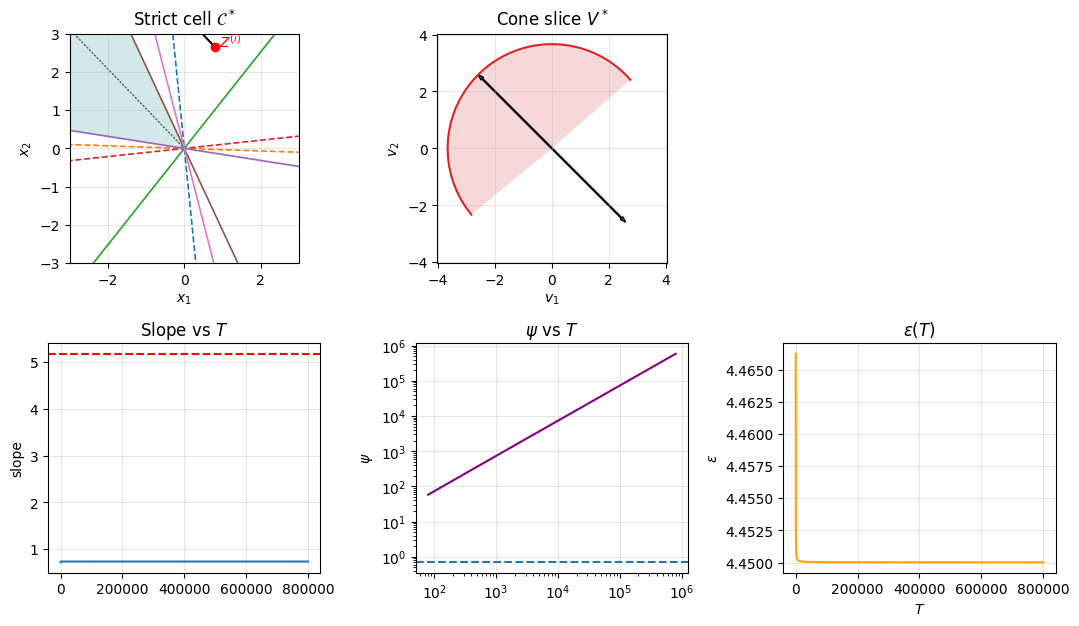

In [627]:
# ================================================================
# 0.  Assumed to exist already:
#     W1, W2, D_star, J_star, radius, u, pair, X, y, W_true …
# ================================================================

# ------------------------------------------------  helper grid ---
grid = np.linspace(-10, 10, 1000)
xx, yy = np.meshgrid(grid, grid)

# strict-cell mask
cond = np.ones_like(xx, dtype=bool)
for k in range(W1.shape[0]):
    lin = W1[k, 0] * xx + W1[k, 1] * yy
    if D_star[k, k]:
        cond &= (lin > 0)
    else:
        cond &= (lin < 0)

# reproducible test point and ray
# rng   = np.random.default_rng(SEED)
Z_i   = rng.uniform(low=-3, high=3, size=2)
# Z_i = np.array([1.58398759, 2.72918996])
e     = np.eye(J_star.shape[0])
c, j_plus = info['pair']
w_vec = (radius / np.sqrt(2)) * (e[j_plus] - e[c])
u = np.linalg.solve(J_star, w_vec)
T_max = 2.0
ray_end = Z_i + T_max * u

# ------------------------------------------------------------------
# build the GridSpec 2 (rows) × 3 (cols)
# ------------------------------------------------------------------
fig = plt.figure(figsize=(13, 7))
gs  = fig.add_gridspec(2, 3, wspace=0.35, hspace=0.35)

# ================================================================
# 1.  strict ReLU cell with Z^{(i)} and ray
# ================================================================
ax0 = fig.add_subplot(gs[0, 0])
ax0.contourf(xx, yy, cond.astype(int), levels=[0.5, 1.5], alpha=0.20)
x_line = np.linspace(-4, 4, 900)
for k in range(W1.shape[0]):
    a, b = W1[k]
    style = '-' if D_star[k, k] else '--'
    if abs(b) > 1e-12:
        ax0.plot(x_line, (-a / b) * x_line, style, lw=1.2)
    else:
        ax0.axvline(0, ls=style, lw=1.2)
ax0.plot(*Z_i, 'ro'); ax0.text(Z_i[0]+.1, Z_i[1], r'$Z^{(i)}$', color='r')
ax0.arrow(Z_i[0], Z_i[1], *(ray_end - Z_i),
          width=0.015, head_width=.1, head_length=.15, length_includes_head=True)
ax0.arrow(0, 0, *u, ls=':', alpha=.5,
          head_width=.07, head_length=.1, length_includes_head=True)
ax0.set_xlim([-3, 3]); ax0.set_ylim([-3, 3])
ax0.set_aspect('equal'); ax0.grid(alpha=.3)
ax0.set_xlabel('$x_1$'); ax0.set_ylabel('$x_2$')
ax0.set_title('Strict cell $\\mathcal{C}^*$')

# ================================================================
# 2.  filled cone slice V* and all admissible w-vectors
# ================================================================
n   = J_star.shape[0]
Jinv = np.linalg.inv(J_star)
A = np.vstack([(1 if D_star[k,k] else -1) * (W1[k] @ Jinv) for k in range(n)])

theta = np.linspace(0, 2*np.pi, 2000, endpoint=False)
circle_pts = radius * np.c_[np.cos(theta), np.sin(theta)]
mask = (A @ circle_pts.T > 0).all(0)
idx   = np.where(mask)[0]
splits = np.where(np.diff(idx)!=1)[0]+1
segments = np.split(idx, splits)
if segments[0][0]==0 and segments[-1][-1]==len(theta)-1:
    segments[0] = np.r_[segments[-1], segments[0]]; segments.pop()
arc = circle_pts[max(segments, key=len)]

ax1 = fig.add_subplot(gs[0, 1])
ax1.add_patch(Polygon(np.vstack([[0, 0], arc]), facecolor='#d62728', alpha=.18))
ax1.plot(arc[:, 0], arc[:, 1], color='#d62728')
ax1.add_patch(plt.Circle((0, 0), radius, ls='--', fc='none'))
for c_ in range(n):
    for j_ in range(n):
        if j_ == c_: continue
        wv = (radius / np.sqrt(2)) * (e[j_] - e[c_])
        ax1.arrow(0, 0, *wv, width=.009 * radius,
                  head_width=.035 * radius, head_length=.055 * radius,
                  length_includes_head=True)
ax1.set_aspect('equal'); ax1.grid(alpha=.3)
ax1.set_xlabel('$v_1$'); ax1.set_ylabel('$v_2$')
ax1.set_title('Cone slice $V^*$')

# leave gs[0,2] empty
fig.add_subplot(gs[0, 2]).axis('off')

# ================================================================
# 3.  Assumption A2 diagnostics (slope, ψ, ε)
# ================================================================
# def psi_beta(z):
#     z_proj = W2 @ np.maximum(W1 @ z, 0.)
#     p = np.exp(z_proj - np.max(z_proj)); p /= p.sum()
#     return -np.log(p[c])        # true label = c

psi_0 = psi_beta(Z_i)
L_const = np.sqrt(2) * np.linalg.norm(J_star, 2)
T_vals = np.arange(1, 1e4)
norm_u = np.linalg.norm(u)
psi_vals, slopes, eps, d_vals = [], [], [], []
for T in T_vals:
    Z_eps = Z_i + T * u
    psi_t  = psi_beta(Z_i + T*u)
    psi_vals.append(psi_t)
    d_val = np.linalg.norm(Z_eps - Z_i)
    # Lipschitz ratio along u
    slope  = (psi_t - psi_0) / np.linalg.norm(Z_eps - Z_i)
    slopes.append(slope)
    d_vals.append(d_val)
    eps.append(L_const - slope)



ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])

ax2.plot(d_vals, slopes); ax2.axhline(L_const, ls='--', color='r')
ax2.set_title('Slope vs $T$'); ax2.set_ylabel('slope'); ax2.grid(alpha=.3)

ax3.plot(d_vals, psi_vals, color='purple'); ax3.axhline(psi_0, ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title(r'$\psi$ vs $T$'); ax3.set_ylabel(r'$\psi$'); ax3.grid(alpha=.3)

ax4.plot(d_vals, eps, color='orange')
ax4.set_title(r'$\varepsilon(T)$'); ax4.set_xlabel('$T$'); ax4.set_ylabel(r'$\varepsilon$')
ax4.grid(alpha=.3)

plt.show()

In [628]:
# ----- parameters ------------------------------------------------
NUM_PER_CLASS = 2                           # how many points per label (0 / 1)
BOX           = np.array([-500, 500])     # grid range     

# ----- 1. sample points until we have both labels ----------------
rng     = np.random.default_rng(SEED)
points0 = []
points1 = []

# ------------------------------------------------------------------
# distance threshold (feel free to tune)
# ------------------------------------------------------------------
R_MIN = 6          # reject a candidate if it is nearer than this

def too_close(pt, bank):
    """True if pt is within R_MIN of any point in bank (list of arrays)."""
    if not bank:                      # empty list → nothing to check
        return False
    bank_arr = np.vstack(bank)        # shape (k,2)
    return np.any(np.linalg.norm(bank_arr - pt, axis=1) < R_MIN)

# ------------------------------------------------------------------
# sampling loop with spacing constraint
# ------------------------------------------------------------------
pts_all  = np.vstack([points0, points1])           # shape (2·NUM_PER_CLASS, 2)
pts_all  = np.vstack([[100,-10], [10,200],[-100,100], [-16,12]])
labels   = np.array([0]*NUM_PER_CLASS + [1]*NUM_PER_CLASS)

# ----- 2. compute loss (z-coord) for each sampled point ----------
def cross_entropy(student_W1, student_W2, x, true_label):
    h       = np.maximum(x @ student_W1.T, 0.0)
    logits  = h @ student_W2.T
    p       = np.exp(logits - logits.max())
    p      /= p.sum()
    return -np.log(p[true_label])

z_vals = np.array([
    cross_entropy(W1, W2, x, c) for x in pts_all   # c = 0 everywhere
])

# ----- 3. build the surface (same as before) --------------------
grid   = np.linspace(*BOX, 200)
xx, yy = np.meshgrid(grid, grid)
XY     = np.c_[xx.ravel(), yy.ravel()]
y_one  = np.tile(np.array([1, 0]), (XY.shape[0], 1))   # one-hot for class 0

pre     = XY @ W1.T
h       = np.maximum(pre, 0.0)
logits  = h @ W2.T
p_grid  = np.exp(logits - logits.max(axis=1, keepdims=True))
p_grid /= p_grid.sum(axis=1, keepdims=True)
loss    = (-np.sum(y_one * np.log(p_grid), axis=1)
          ).reshape(xx.shape)

# ----- 4. plot surface + scatter points -------------------------
fig = go.Figure()

# ─── loss surface ───────────────────────────────────────────────
fig.add_trace(
    go.Surface(
        x=xx, y=yy, z=loss,
        colorscale='Viridis', opacity=0.8,
        showscale=True, colorbar=dict(title='Loss', x=-0.15)
    )
)

# convenience masks
mask0 = labels == 0
mask1 = ~mask0

# ─── 3-D scatter (true points) ──────────────────────────────────
fig.add_trace(
    go.Scatter3d(
        x=pts_all[mask0, 0], y=pts_all[mask0, 1], z=z_vals[mask0],
        mode='markers',
        marker=dict(size=5, color='red'),
        showlegend=False
    )
)
fig.add_trace(
    go.Scatter3d(
        x=pts_all[mask1, 0], y=pts_all[mask1, 1], z=z_vals[mask1],
        mode='markers',
        marker=dict(size=5, color='red'),
        showlegend=False
    )
)

# ─── projections onto the x₁x₂-plane (z = 0) ────────────────────
fig.add_trace(
    go.Scatter3d(
        x=pts_all[mask0, 0], y=pts_all[mask0, 1], z=np.zeros_like(z_vals[mask0]),
        mode='markers',
        marker=dict(size=4, color='red', symbol='diamond'),
        showlegend=False
    )
)
fig.add_trace(
    go.Scatter3d(
        x=pts_all[mask1, 0], y=pts_all[mask1, 1], z=np.zeros_like(z_vals[mask1]),
        mode='markers',
        marker=dict(size=4, color='red', symbol='diamond'),
        showlegend=False
    )
)

# ─── dashed vertical connectors ─────────────────────────────────
for (x, y, z) in zip(pts_all[:, 0], pts_all[:, 1], z_vals):
    fig.add_trace(
        go.Scatter3d(
            x=[x, x], y=[y, y], z=[0, z],
            mode='lines',
            line=dict(color='gray', dash='dash'),
            showlegend=False        # one legend entry is enough
        )
    )
    
# ─── witness direction u as arrows ─────────────────────────────
T_LEN   = 5                     # arrow length in input space
u_xy = u
# u_xy    = u / np.linalg.norm(u)   # witness direction projected to (x1, x2)

for idx, (x0, y0) in enumerate(pts_all):
    #  end-point of the arrow in the plane  z = 0
    x1, y1 = x0 + T_LEN * u_xy[0], y0 + T_LEN * u_xy[1]

    # --- (a) loss at the ray endpoint ---------------------------------
    z_end  = cross_entropy(W1, W2, np.array([x1, y1]), c)

    # --- (b) endpoint marker in the plane (×) -------------------------
    fig.add_trace(
        go.Scatter3d(
            x=[x1], y=[y1], z=[0],
            mode='markers',
            marker=dict(size=2, color='black', symbol='x'),
            showlegend=False
        )
    )

    # --- (c) endpoint marker on the surface (■) -----------------------
    fig.add_trace(
        go.Scatter3d(
            x=[x1], y=[y1], z=[z_end],
            mode='markers',
            marker=dict(size=2, color='black', symbol='square'),
            showlegend=False
        )
    )

    # --- (d) connector between the two surface points ----------
    fig.add_trace(
        go.Scatter3d(
            x=[x0, x1], y=[y0, y1],
            z=[z_vals[idx], z_end],
            mode='lines',
            line=dict(color='black'),
            showlegend=False
        )
    )

    # --------------------------
    fig.add_trace(
        go.Scatter3d(
            x=[x1, x1], y=[y1, y1], z=[0, z_end],
            mode='lines',
            line=dict(color='gray', dash='dash'),
            showlegend=False        # one legend entry is enough
        )
    )
    
    # line segment (arrow shaft)
    fig.add_trace(
        go.Scatter3d(
            x=[x0, x1],
            y=[y0, y1],
            z=[0, 0],
            mode='lines',
            line=dict(color='black', width=2),
            showlegend=False
        )
    )
    
# ─── layout and camera settings ─────────────────────────────────
fig.update_layout(
    title='Loss surface with teacher-labelled points and projections',
    scene=dict(
        xaxis_title='x₁',
        yaxis_title='x₂',
        zaxis_title='Loss',
        camera=dict(eye=dict(x=1.5, y=1.4, z=1.0))  # nicer default view
    ),
    width=850,
    height=650
)

fig.show()

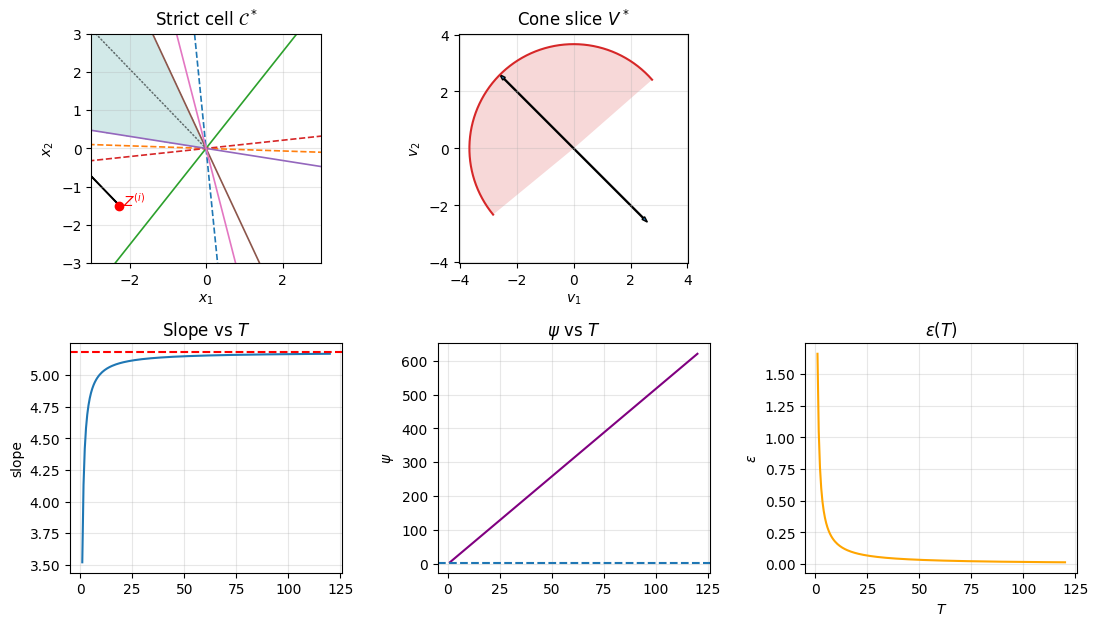

In [629]:
# ================================================================
# 0.  Assumed to exist already:
#     W1, W2, D_star, J_star, radius, u, pair, X, y, W_true …
# ================================================================

# ------------------------------------------------  helper grid ---
grid = np.linspace(-10, 10, 1000)
xx, yy = np.meshgrid(grid, grid)

# strict-cell mask
cond = np.ones_like(xx, dtype=bool)
for k in range(W1.shape[0]):
    lin = W1[k, 0] * xx + W1[k, 1] * yy
    if D_star[k, k]:
        cond &= (lin > 0)
    else:
        cond &= (lin < 0)

# reproducible test point and ray
# rng   = np.random.default_rng(SEED)
Z_i   = rng.uniform(low=-3, high=3, size=2)
# Z_i   = np.array([0, 0])
e     = np.eye(J_star.shape[0])
c, j_plus = info['pair']
w_vec = (radius / np.sqrt(2)) * (e[j_plus] - e[c])
# u     = np.array([-1,1])
T_max = 2.0
ray_end = Z_i + T_max * u

# ------------------------------------------------------------------
# build the GridSpec 2 (rows) × 3 (cols)
# ------------------------------------------------------------------
fig = plt.figure(figsize=(13, 7))
gs  = fig.add_gridspec(2, 3, wspace=0.35, hspace=0.35)

# ==================================================================
# 1. strict ReLU cell  ── axis (0,0)
# ==================================================================
ax0 = fig.add_subplot(gs[0, 0])
ax0.contourf(xx, yy, cond.astype(int), levels=[0.5, 1.5], alpha=0.20)
x_line = np.linspace(-4, 4, 900)
for k in range(W1.shape[0]):
    a, b = W1[k]
    style = '-' if D_star[k, k] else '--'
    if abs(b) > 1e-12:
        ax0.plot(x_line, (-a / b) * x_line, style, lw=1.2)
    else:
        ax0.axvline(0, ls=style, lw=1.2)
ax0.plot(*Z_i, 'ro'); ax0.text(Z_i[0]+.1, Z_i[1], r'$Z^{(i)}$', color='r')
ax0.arrow(Z_i[0], Z_i[1], *(ray_end - Z_i),
          width=0.015, head_width=.1, head_length=.15, length_includes_head=True)
ax0.arrow(0, 0, *u, ls=':', alpha=.5,
          head_width=.07, head_length=.1, length_includes_head=True)
ax0.set_xlim([-3, 3]); ax0.set_ylim([-3, 3])
ax0.set_aspect('equal'); ax0.grid(alpha=.3)
ax0.set_xlabel('$x_1$'); ax0.set_ylabel('$x_2$')
ax0.set_title('Strict cell $\\mathcal{C}^*$')

# ================================================================
# 2.  filled cone slice V* and all admissible w-vectors
# ================================================================
n   = J_star.shape[0]
Jinv = np.linalg.inv(J_star)
A = np.vstack([(1 if D_star[k,k] else -1) * (W1[k] @ Jinv) for k in range(n)])

theta = np.linspace(0, 2*np.pi, 2000, endpoint=False)
circle_pts = radius * np.c_[np.cos(theta), np.sin(theta)]
mask = (A @ circle_pts.T > 0).all(0)
idx   = np.where(mask)[0]
splits = np.where(np.diff(idx)!=1)[0]+1
segments = np.split(idx, splits)
if segments[0][0]==0 and segments[-1][-1]==len(theta)-1:
    segments[0] = np.r_[segments[-1], segments[0]]; segments.pop()
arc = circle_pts[max(segments, key=len)]

ax1 = fig.add_subplot(gs[0, 1])
ax1.add_patch(Polygon(np.vstack([[0, 0], arc]), facecolor='#d62728', alpha=.18))
ax1.plot(arc[:, 0], arc[:, 1], color='#d62728')
ax1.add_patch(plt.Circle((0, 0), radius, ls='--', fc='none'))
for c_ in range(n):
    for j_ in range(n):
        if j_ == c_: continue
        wv = (radius / np.sqrt(2)) * (e[j_] - e[c_])
        ax1.arrow(0, 0, *wv, width=.009 * radius,
                  head_width=.035 * radius, head_length=.055 * radius,
                  length_includes_head=True)
ax1.set_aspect('equal'); ax1.grid(alpha=.3)
ax1.set_xlabel('$v_1$'); ax1.set_ylabel('$v_2$')
ax1.set_title('Cone slice $V^*$')

# leave gs[0,2] empty
fig.add_subplot(gs[0, 2]).axis('off')

# ================================================================
# 3.  Assumption A2 diagnostics (slope, ψ, ε)
# ================================================================
def psi_beta(z):
    z_proj = W2 @ np.maximum(W1 @ z, 0.)
    p = np.exp(z_proj - np.max(z_proj)); p /= p.sum()
    return -np.log(p[c])        # true label = c

psi_0 = psi_beta(Z_i)
L_const = np.sqrt(2)*radius
T_vals = np.linspace(1, 120, 200)
psi_vals, slopes, eps = [], [], []
for T in T_vals:
    psi_t = psi_beta(Z_i + T*u)
    psi_vals.append(psi_t)
    slope = (psi_t - psi_0)/T
    slopes.append(slope); eps.append(L_const - slope)

ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])

ax2.plot(T_vals, slopes); ax2.axhline(L_const, ls='--', color='r')
ax2.set_title('Slope vs $T$'); ax2.set_ylabel('slope'); ax2.grid(alpha=.3)

ax3.plot(T_vals, psi_vals, color='purple'); ax3.axhline(psi_0, ls='--')
ax3.set_title(r'$\psi$ vs $T$'); ax3.set_ylabel(r'$\psi$'); ax3.grid(alpha=.3)

ax4.plot(T_vals, eps, color='orange')
ax4.set_title(r'$\varepsilon(T)$'); ax4.set_xlabel('$T$'); ax4.set_ylabel(r'$\varepsilon$')
ax4.grid(alpha=.3)

plt.show()

## Assumptions Check

$$
\text{int}(\text{rec}(\mathcal C^*)) \text{ is non-empty and open in } \mathbb{R}^{n}
$$

| **Random data**                  | For every Monte-Carlo trial you draw two Gaussian weight matrices:<br>• `W1 ∈ ℝ^{n₁×n}`  and  • `W2 ∈ ℝ^{K×n₁}`                                                                        |
|--------------------------------| --------------------------------------------------------------------------------------------------------------------------|
| **Compute the “best” ReLU mask** | `compute_D_star` searches for the diagonal mask **D\*** that maximises ‖W₂ D W₁‖₂.<br>  – If *n₁* ≤ 12 it enumerates all $2^{n₁}$ masks.<br>  – Otherwise it samples 4096 random masks. |
| **Deterministic Ω-test**         | Given *W₁* and **D\***, form a block matrix **B** whose rows are ±rows of W₁.  An LP checks feasibility of **B u ≥ 1**. Success ⇔ Ω contains an interior point.                        |

In [625]:
"""
Deterministic test of Assumption T2
----------------------------------
Ω := int( rec( C* ) ) ≠ ∅   ⇔   ∃ u  with  B u > 0,
where
    B = [ W1_i          ]_{i : (D*)_{ii}=1 }
        [ -W1_j ]_{j : (D*)_{jj}=0 }

The feasibility of  B u ≥ 1  is checked once via a linear-program (LP).
No random search in the cone is required.
"""
# ---------------------------------------------------------------------
# 1.  deterministic Ω–test
# ---------------------------------------------------------------------
def has_nonempty_omega(W1: np.ndarray, D_star: np.ndarray) -> bool:
    """Return True  ⇔  Ω = int(rec(C*)) is non-empty."""
    s = 2 * D_star.diagonal() - 1          # +1 (active) / −1 (inactive)
    B = s[:, None] * W1                    # rows are  ±W1_i
    m, n = B.shape

    # LP feasibility:  find u  s.t.  B u ≥ 1
    res = linprog(
        c=np.zeros(n),                     # dummy objective
        A_ub=-B,                           #  B u ≥ 1  ⟺  -B u ≤ -1
        b_ub=-np.ones(m),
        bounds=[(None, None)] * n,         # u free in ℝⁿ
        method="highs",
        options={"presolve": True},
    )
    return res.success


# ---------------------------------------------------------------------
# 2.  compute D*  (exact enumeration if n1 ≤ 12, else random search)
# ---------------------------------------------------------------------
def compute_D_star(W1: np.ndarray, W2: np.ndarray, nsamples: int = 4096):
    """
    Approximate argmax_D || W2 D W1 ||_2.

    •  If n1 ≤ 12, enumerate all 2^{n1} masks exactly.
    •  Otherwise, draw `nsamples` random masks.
    """
    n1 = W1.shape[0]
    best_norm, best_mask = -np.inf, None
    rng = np.random.default_rng()

    def masks():
        if n1 <= 12:
            for idx in range(1 << n1):
                yield np.array([(idx >> k) & 1 for k in range(n1)], dtype=float)
        else:
            for _ in range(nsamples):
                yield rng.integers(0, 2, n1).astype(float)

    for mask in masks():
        D = np.diag(mask)
        nrm = np.linalg.norm(W2 @ D @ W1, 2)
        if nrm > best_norm:
            best_norm, best_mask = nrm, mask

    return np.diag(best_mask)


# ---------------------------------------------------------------------
# 3.  empirical probability that T2 holds (deterministic Ω-test inside)
# ---------------------------------------------------------------------
def prob_T2(
    n: int,
    n1: int,
    K: int,
    trials: int = 1000,
    nsamples_D: int = 4096,
) -> float:
    """
    Monte-Carlo over random (W1, W2) with *deterministic* Ω-test.

    Returns empirical P[ Ω ≠ ∅ ].
    """
    good = 0
    rng = np.random.default_rng()

    for seed in range(trials):
        rng = np.random.default_rng(seed)
        W1 = rng.standard_normal((n1, n))
        W2 = rng.standard_normal((K, n1))
        D_star = compute_D_star(W1, W2, nsamples=nsamples_D)
        if has_nonempty_omega(W1, D_star):
            good += 1

    return good / trials


# ---------------------------------------------------------------------
# 4.  sweep the *extreme* regimes only
#     (i)  n  ≪ n1   :  fix a large n1, vary a much smaller n
#     (ii) n1 ≫ n    :  fix a small  n,  vary a much larger n1
# ---------------------------------------------------------------------
TRIALS       = 50
N_SAMPLES_D  = 4096

# (i)  n  ≪ n1
N1_LARGE        = 25                          # keep n1 fixed and large
N_SMALL_RANGE   = np.arange(2, N1_LARGE + 10)  # n ranges up to n1
P_vs_n_small    = [
    prob_T2(n, N1_LARGE, K=3, trials=TRIALS, nsamples_D=N_SAMPLES_D)
    for n in N_SMALL_RANGE
]

# (ii) n1 ≫ n
N_SMALL_FIXED   = 5
N1_LARGE_RANGE  = np.arange(1, 41)  # n1 ranges far past n
P_vs_n1_large   = [
    prob_T2(N_SMALL_FIXED, n1, K=3, trials=TRIALS, nsamples_D=N_SAMPLES_D)
    for n1 in N1_LARGE_RANGE
]

# ---------------------------------------------------------------------
# 5.  plot the two interesting curves
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (i) n ≪ n1
axes[0].plot(N_SMALL_RANGE, P_vs_n_small, marker="o")
axes[0].set_title(r"$\Pr[\Omega\neq\varnothing]$ vs $n$ "
                  + rf"(fixed $n_1={N1_LARGE}\gg n$)")
axes[0].set_xlabel("$n$")
axes[0].set_ylabel("Empirical probability")
axes[0].grid(alpha=0.3)

# (ii) n1 ≫ n
axes[1].plot(N1_LARGE_RANGE, P_vs_n1_large, marker="o", color="tab:orange")
axes[1].set_title(r"$\Pr[\Omega\neq\varnothing]$ vs $n_1$ "
                  + rf"(fixed $n={N_SMALL_FIXED}\ll n_1$)")
axes[1].set_xlabel("$n_1$")
axes[1].set_ylabel("Empirical probability")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

$$
\text{rank}(J^*)=K
$$

| **Random weights**    | • `random_W1_full_rank` keeps resampling until W₁ has full rank min(n₁,n).<br>• W₂ is an unconstrained Gaussian.|
| - | - |
| **Mask search**           | Exhaustive if n₁ ≤ 10, else **1024** random masks per trial.|

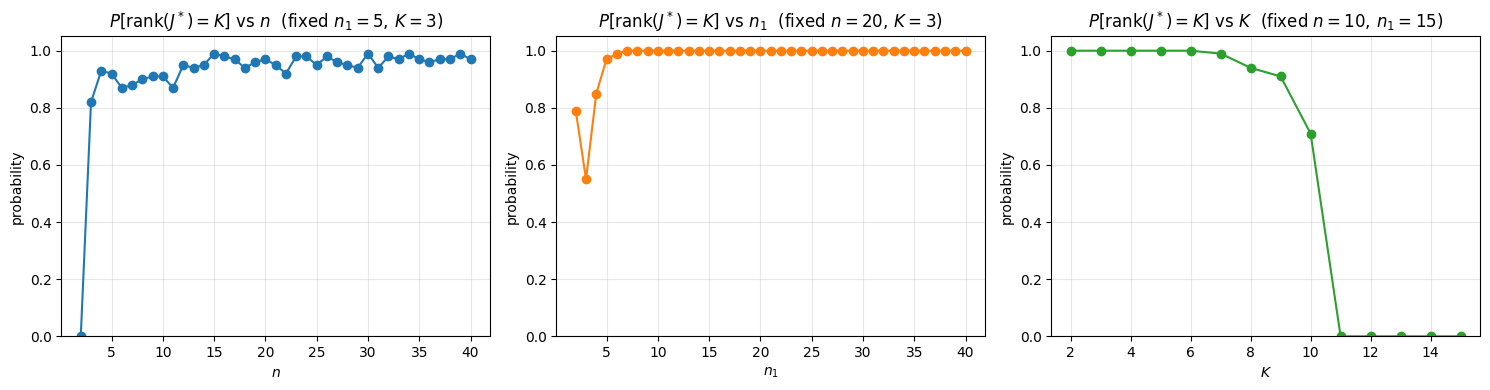

In [ ]:
# ------------------------------------------------------------------ #
# 1. helpers                                                         #
# ------------------------------------------------------------------ #
def random_W1_full_rank(rng, n1: int, n: int) -> np.ndarray:
    """
    Gaussian W1 with full rank min(n1, n).  Works for both n1 ≤ n and n1 > n.
    """
    r_target = min(n1, n)
    while True:                              # (rank–deficiency has prob. 0,
        W1 = rng.standard_normal((n1, n))    #  loop exits almost immediately)
        if np.linalg.matrix_rank(W1) == r_target:
            return W1


def random_W2_any(rng, K: int, n1: int) -> np.ndarray:
    return rng.standard_normal((K, n1))


def spectral_norm(A: np.ndarray) -> float:
    return np.linalg.svd(A, compute_uv=False)[0]


def best_mask(W2, W1, rng, sample_masks="all"):
    """
    Return argmax_D || W2 D W1 ||_2.
      • if `sample_masks="all"` and n1≤10  ⇒ exhaustive search
      • else                              ⇒ random masks
    """
    n1 = W1.shape[0]
    best_val, D_star = -np.inf, None

    if sample_masks == "all":
        mask_iter = product([0, 1], repeat=n1)
    else:                                     # sample_masks = int (# of draws)
        mask_iter = (rng.integers(0, 2, size=n1) for _ in range(sample_masks))

    for bits in mask_iter:
        D = np.diag(bits)
        val = spectral_norm(W2 @ D @ W1)
        if val > best_val:
            best_val, D_star = val, D
    return D_star


# ------------------------------------------------------------------ #
# 2. Monte-Carlo estimator of P[ rank(J*) = K ]  (Assumption T3)      #
# ------------------------------------------------------------------ #
def prob_T3(n, n1, K, trials=1000, mask_sampling="all"):
    """
    Empirical  P[ rank(J*) = K ]  over random (W1, W2) pairs.
    No restriction on n1 versus n.
    """
    good = 0
    for seed in range(trials):
        rng  = np.random.default_rng(seed)
        W1   = random_W1_full_rank(rng, n1, n)        # full rank  min(n1, n)
        W2   = random_W2_any(rng, K, n1)              # unconstrained
        Dstar = best_mask(W2, W1, rng, mask_sampling)
        Jstar = W2 @ Dstar @ W1
        if np.linalg.matrix_rank(Jstar) == K:         # Assumption T3
            good += 1
    return good / trials


# ------------------------------------------------------------------ #
# 3. experiment settings                                             #
# ------------------------------------------------------------------ #
TRIALS        = 100             # MC repetitions per point
MASK_THRESH   = 10              # exhaustive masks if n1 ≤ 10
N_SAMPLES_D   = 1024            # random masks otherwise

# (1) vary n  with fixed n1 (n may be ≪ or ≫ n1)
N1_FIX, K_FIX = 5, 3
N_RANGE       = np.arange(2, 41)

# (2) vary n1 with fixed n (n1 may exceed n)
N_FIX, K_FIX2 = 20, 3
N1_RANGE      = np.arange(2, 41)

# (3) vary K  with fixed (n, n1)
N_FIX3, N1_FIX3 = 10, 15
K_RANGE         = np.arange(2, N1_FIX3 + 1)   # may exceed n ⇒ prob 0 for K>n


# ------------------------------------------------------------------ #
# 4. Monte-Carlo runs                                                #
# ------------------------------------------------------------------ #
prob_vs_n = [
    prob_T3(
        n, N1_FIX, K_FIX,
        trials=TRIALS,
        mask_sampling="all" if N1_FIX <= MASK_THRESH else N_SAMPLES_D
    )
    for n in N_RANGE
]

prob_vs_n1 = [
    prob_T3(
        N_FIX, n1, min(K_FIX2, n1, N_FIX),   # keep K ≤ min(n1, n)
        trials=TRIALS,
        mask_sampling="all" if n1 <= MASK_THRESH else N_SAMPLES_D
    )
    for n1 in N1_RANGE
]

prob_vs_K = [
    prob_T3(
        N_FIX3, N1_FIX3, K,
        trials=TRIALS,
        mask_sampling="all" if N1_FIX3 <= MASK_THRESH else N_SAMPLES_D
    )
    for K in K_RANGE
]


# ------------------------------------------------------------------ #
# 5. plots                                                           #
# ------------------------------------------------------------------ #
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (1)  vs n
axes[0].plot(N_RANGE, prob_vs_n, marker='o')
axes[0].set_title(
    rf'$P[\operatorname{{rank}}(J^*)=K]$ vs $n$  '
    rf'(fixed $n_1={N1_FIX},\,K={K_FIX}$)'
)
axes[0].set_xlabel('$n$')
axes[0].set_ylabel('probability')
axes[0].grid(alpha=0.3)
axes[0].set_ylim(0, 1.05)

# (2)  vs n1
axes[1].plot(N1_RANGE, prob_vs_n1, marker='o', color='tab:orange')
axes[1].set_title(
    rf'$P[\operatorname{{rank}}(J^*)=K]$ vs $n_1$  '
    rf'(fixed $n={N_FIX},\,K={K_FIX2}$)'
)
axes[1].set_xlabel('$n_1$')
axes[1].set_ylabel('probability')
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1.05)

# (3)  vs K
axes[2].plot(K_RANGE, prob_vs_K, marker='o', color='tab:green')
axes[2].set_title(
    rf'$P[\operatorname{{rank}}(J^*)=K]$ vs $K$  '
    rf'(fixed $n={N_FIX3},\,n_1={N1_FIX3}$)'
)
axes[2].set_xlabel('$K$')
axes[2].set_ylabel('probability')
axes[2].grid(alpha=0.3)
axes[2].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

| **Typical “wide layer” regime** | All experiments take **n₁ > n** because that’s the modern setting.                                                                                        |
| ------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Random weights**              | W₁ is resampled until it has full column rank n (because n₁ > n).  W₂ is Gaussian.                                                                        |
| **Mask search**                 | Same enumeration / random-sampling rule; random pool size **512** when needed.                                                                            |
| **Feasibility tests**           | • Check rank(J\*) = K.<br>• Solve a single LP (`satisfies_T4`) that enforces the directional equality in T4.<br>A trial is a “success” only if both pass. |

$$
\exists\,u\in\text{rec}(\mathcal C^*)\text{ with }
J^*u=\frac{\|J^*\|_2}{\sqrt2}(e_{j_+}-e_c)
$$

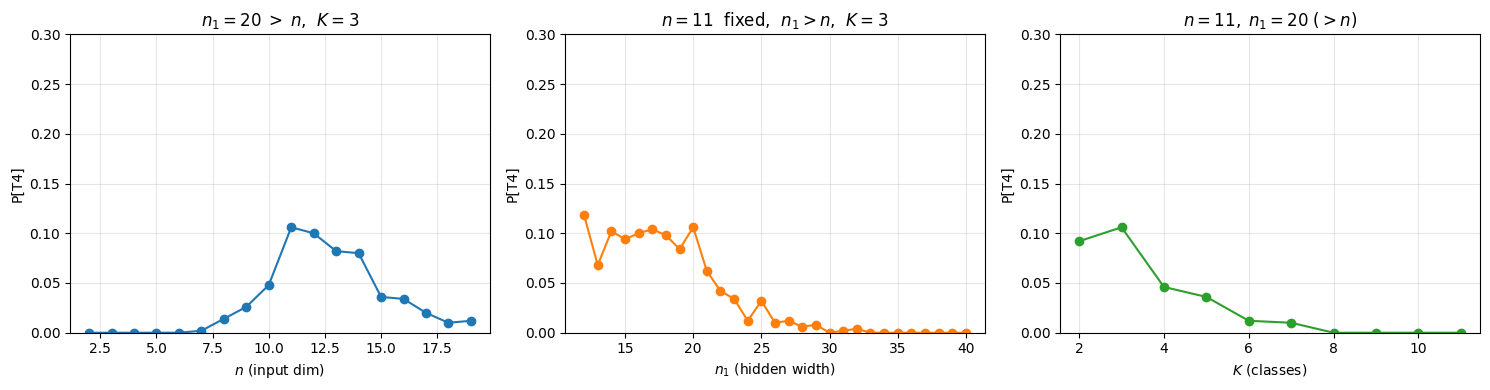

In [ ]:
"""
Deterministic Monte-Carlo test for Assumption T4
*Now with the realistic regime  n₁ > n  everywhere.*
"""
# ------------------------------------------------------------------ #
# 1.  helper functions                                               #
# ------------------------------------------------------------------ #
def random_W1_full_rank(rng, n1: int, n: int) -> np.ndarray:
    """Gaussian W1 of shape (n1, n) having rank = n  (works for n1 > n)."""
    while True:
        W1 = rng.standard_normal((n1, n))
        if np.linalg.matrix_rank(W1) == n:   # full column rank
            return W1


def random_W2_any(rng, K: int, n1: int) -> np.ndarray:
    return rng.standard_normal((K, n1))


def spectral_norm(A: np.ndarray) -> float:
    return np.linalg.svd(A, compute_uv=False)[0]


def best_mask(W2, W1, rng, sample_masks="all"):
    """
    Arg-max over ReLU masks: D* = argmax_D ‖ W₂ D W₁ ‖₂.
    """
    n1 = W1.shape[0]
    if sample_masks == "all":
        mask_iter = product([0, 1], repeat=n1)
    else:
        mask_iter = (rng.integers(0, 2, size=n1) for _ in range(sample_masks))

    best_val, D_star = -np.inf, None
    for bits in mask_iter:
        D = np.diag(bits)
        val = spectral_norm(W2 @ D @ W1)
        if val > best_val:
            best_val, D_star = val, D
    return D_star


# ------------------------------------------------------------------ #
# 2.  deterministic feasibility for T4                               #
# ------------------------------------------------------------------ #
def satisfies_T4(W1, W2, D_star, J_star, c: int = 0) -> bool:
    """
    Check Assumption T4:
        ∃ u  in  rec(C*)   with   J* u = (‖J*‖₂ / √2) (e_{j+} − e_c).
    Feasibility solved as one LP.
    """
    K, _ = W2.shape
    n = W1.shape[1]
    J_norm = spectral_norm(J_star)

    # choose j+ ≠ c
    j_plus = 1 if c == 0 and K > 1 else 0
    if j_plus == c or K == 1:
        return False                     # degenerate output layer

    target = (J_norm / np.sqrt(2)) * (np.eye(K)[j_plus] - np.eye(K)[c])

    # build B  (face normals of recession cone)
    s = 2 * D_star.diagonal() - 1
    B = s[:, None] * W1
    m = B.shape[0]

    # decision vars  z = [u (n), t]
    c_vec = np.zeros(n + 1); c_vec[-1] = -1          # maximise t → minimise -t
    A_ub  = np.hstack([-B, np.ones((m, 1))])         # -B u + t ≤ 0  ⇒  B u ≥ t
    b_ub  = np.zeros(m)
    A_eq  = np.hstack([J_star, np.zeros((K, 1))])
    b_eq  = target
    bounds = [(None, None)] * n + [(0, None)]        # t ≥ 0

    res = linprog(c_vec, A_ub, b_ub, A_eq, b_eq, bounds,
                  method="highs", options={"presolve": True})
    return res.success and res.x[-1] > 1e-6          # strict interior


# ------------------------------------------------------------------ #
# 3.  Monte-Carlo estimator                                          #
# ------------------------------------------------------------------ #
def estimate_proportion(n, n1, K, *, trials=100, mask_sampling="all"):
    """
    Empirical P[T4] with n₁ > n allowed and typical in practice.
    """
    good = 0
    for seed in range(trials):
        rng = np.random.default_rng(seed)

        W1 = random_W1_full_rank(rng, n1, n)
        W2 = random_W2_any(rng, K, n1)

        D_star = best_mask(W2, W1, rng, mask_sampling)
        J_star = W2 @ D_star @ W1

        if np.linalg.matrix_rank(J_star) == K and satisfies_T4(W1, W2, D_star, J_star):
            good += 1
    return good / trials


# ------------------------------------------------------------------ #
# 4.  experiment configuration  (n₁ always > n)                      #
# ------------------------------------------------------------------ #
TRIALS        = 500
MASK_LIMIT    = 10
RAND_MASKS    = 512

# (1) fix n₁ large, vary smaller n (< n₁)
N1_FIXED, K_FIXED = 20, 3
N_RANGE = np.arange(2, N1_FIXED)          # 2 … 19  (all < n₁)
prop_vs_n = [
    estimate_proportion(
        n, N1_FIXED, K_FIXED,
        trials=TRIALS,
        mask_sampling="all" if N1_FIXED <= MASK_LIMIT else RAND_MASKS,
    )
    for n in N_RANGE
]

# (2) fix n small, let n₁ grow (n₁ > n always)
N_FIXED, K_FIXED2 = 11, 3
N1_RANGE = np.arange(N_FIXED + 1, 41)     # 11 … 40
prop_vs_n1 = [
    estimate_proportion(
        N_FIXED, n1, min(K_FIXED2, N_FIXED),   # keep K ≤ n
        trials=TRIALS,
        mask_sampling="all" if n1 <= MASK_LIMIT else RAND_MASKS,
    )
    for n1 in N1_RANGE
]

# (3) vary K with n₁ > n
N_FIXED3, N1_FIXED3 = 11, 20
K_RANGE = np.arange(2, N_FIXED3 + 1)      # up to n (rank cap)
prop_vs_K = [
    estimate_proportion(
        N_FIXED3, N1_FIXED3, K,
        trials=TRIALS,
        mask_sampling="all" if N1_FIXED3 <= MASK_LIMIT else RAND_MASKS,
    )
    for K in K_RANGE
]

# ------------------------------------------------------------------ #
# 5.  plots                                                          #
# ------------------------------------------------------------------ #
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(N_RANGE, prop_vs_n, marker='o')
axes[0].set_title(fr'$n_1={N1_FIXED}\;>\;n$,  $K={K_FIXED}$')
axes[0].set_xlabel('$n$ (input dim)')
axes[0].set_ylabel('P[T4]')

axes[1].plot(N1_RANGE, prop_vs_n1, marker='o', color='tab:orange')
axes[1].set_title(fr'$n={N_FIXED}$  fixed,  $n_1>n$,  $K={K_FIXED2}$')
axes[1].set_xlabel('$n_1$ (hidden width)')
axes[1].set_ylabel('P[T4]')

axes[2].plot(K_RANGE, prop_vs_K, marker='o', color='tab:green')
axes[2].set_title(fr'$n={N_FIXED3},\;n_1={N1_FIXED3}\;(>n)$')
axes[2].set_xlabel('$K$ (classes)')
axes[2].set_ylabel('P[T4]')

for ax in axes:
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 0.3)

plt.tight_layout()
plt.show()